In [29]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [30]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [31]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [32]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [33]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [34]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [35]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [36]:
df

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,2,12,3,3,1,4,1,2,...,15,4,0,2,3,10,0,282.466667,0.789828,3.2
879,37,0,2,16,2,4,1,4,1,3,...,13,2,2,3,2,17,0,76.291667,0.711223,3.2
880,33,1,1,6,4,2,1,1,2,5,...,18,2,0,2,2,11,7,272.881579,0.751820,2.0
881,33,0,2,4,1,3,0,2,2,5,...,12,1,0,2,4,3,2,208.666667,0.862289,2.2


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [38]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


<h3>Feature selection</h3>

In [39]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.066206
RelationshipSatisfaction                           0.017531
StockOptionLevel                                   0.014698
JobSatisfaction                                    0.014058
NumCompaniesWorked                                 0.010794
JobLevel                                           0.009380
YearsInCurrentRole                                 0.006734
YearsAtCompany                                     0.006489
Age                                                0.004731
OverallSatisfaction                                0.003661
JobInvolvement                                     0.003628
JobRole                                            0.001118
WorkLifeBalance                                    0.000772
Gender                                             0.000703
TaxRate                                            0.000680
TrainingTimesLastYear                              -0.000218
BusinessTravel                         

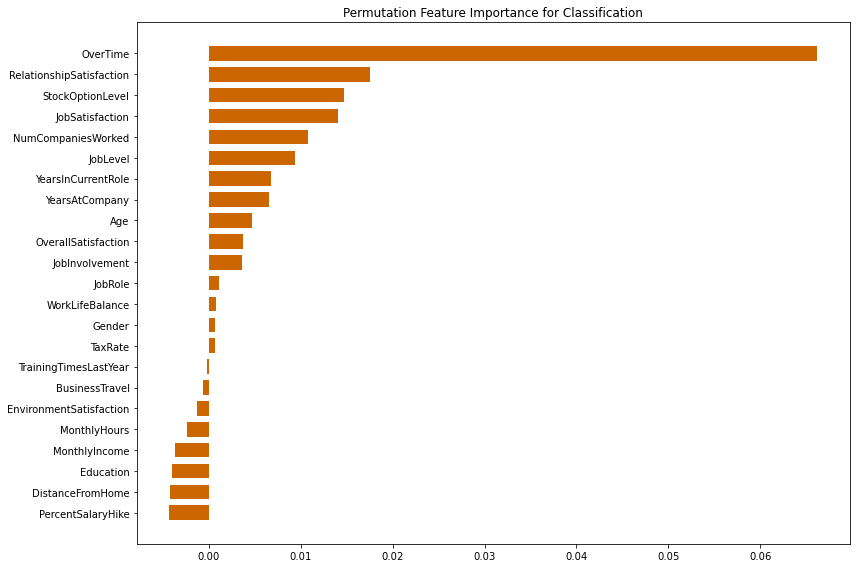

In [40]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [41]:
df = df.drop(['YearsInCurrentRole','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel','PercentSalaryHike','TaxRate'], axis = 1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   DistanceFromHome          883 non-null    int64  
 3   EnvironmentSatisfaction   883 non-null    int64  
 4   JobInvolvement            883 non-null    int64  
 5   JobLevel                  883 non-null    int64  
 6   JobRole                   883 non-null    int64  
 7   JobSatisfaction           883 non-null    int64  
 8   NumCompaniesWorked        883 non-null    int64  
 9   OverTime                  883 non-null    int64  
 10  RelationshipSatisfaction  883 non-null    int64  
 11  StockOptionLevel          883 non-null    int64  
 12  TrainingTimesLastYear     883 non-null    int64  
 13  WorkLifeBalance           883 non-null    int64  
 14  OverallSat

<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [43]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [44]:
remaining_columns = []

for column in columns_to_discretize:
    if column in df:
        remaining_columns.append(column)
        
remaining_columns

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [45]:
columns_to_discretize = remaining_columns
columns_to_discretize

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [46]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','NumCompaniesWorked'])], 
                       remainder = "drop")

In [47]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,11,3,9,0,3,0,2,2,2.6
1,36,0,1,2,3,5,8,3,1,1,3,1,3,3,2.8
2,25,0,16,3,3,2,5,4,1,1,3,1,4,3,3.2
3,33,0,5,2,3,1,4,2,2,0,2,0,1,3,2.4
4,31,0,9,3,3,1,3,4,1,0,3,0,2,3,3.2


In [48]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,NumCompaniesWorked
0,3.0,1.0,3.0
1,1.0,0.0,0.0
2,0.0,2.0,0.0
3,1.0,0.0,0.0
4,1.0,1.0,0.0


In [49]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,11,3,9,0,3,0,2,2,2.6
1,36,0,1,2,3,5,8,3,1,1,3,1,3,3,2.8
2,25,0,16,3,3,2,5,4,1,1,3,1,4,3,3.2
3,33,0,5,2,3,1,4,2,2,0,2,0,1,3,2.4
4,31,0,9,3,3,1,3,4,1,0,3,0,2,3,3.2


In [50]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [51]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,3.0,0,1.0,2,3,3,11,3,3.0,0,3,0,2,2,2.6
1,1.0,0,0.0,2,3,5,8,3,0.0,1,3,1,3,3,2.8
2,0.0,0,2.0,3,3,2,5,4,0.0,1,3,1,4,3,3.2
3,1.0,0,0.0,2,3,1,4,2,0.0,0,2,0,1,3,2.4
4,1.0,0,1.0,3,3,1,3,4,0.0,0,3,0,2,3,3.2


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    float64
 1   Attrition                 883 non-null    int64  
 2   DistanceFromHome          883 non-null    float64
 3   EnvironmentSatisfaction   883 non-null    int64  
 4   JobInvolvement            883 non-null    int64  
 5   JobLevel                  883 non-null    int64  
 6   JobRole                   883 non-null    int64  
 7   JobSatisfaction           883 non-null    int64  
 8   NumCompaniesWorked        883 non-null    float64
 9   OverTime                  883 non-null    int64  
 10  RelationshipSatisfaction  883 non-null    int64  
 11  StockOptionLevel          883 non-null    int64  
 12  TrainingTimesLastYear     883 non-null    int64  
 13  WorkLifeBalance           883 non-null    int64  
 14  OverallSat

<h3>Divide into features and target</h3>

In [53]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [54]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.580959223265765
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


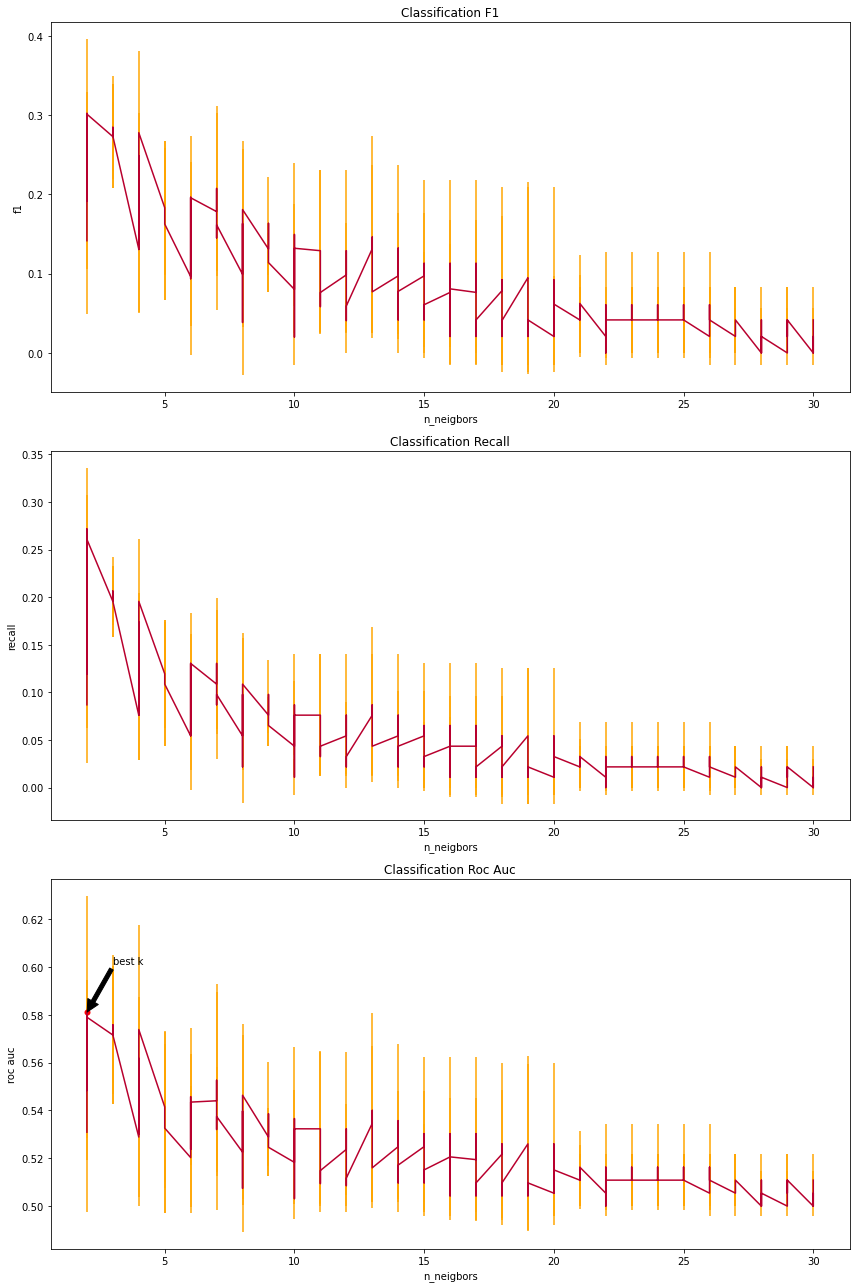



Permutation importances of the training set

OverTime                                           0.009831
JobSatisfaction                                    0.001812
RelationshipSatisfaction                           0.000070
StockOptionLevel                                   0.000067
DistanceFromHome                                   0.000017
EnvironmentSatisfaction                            0.000009
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
NumCompaniesWorked                                 0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



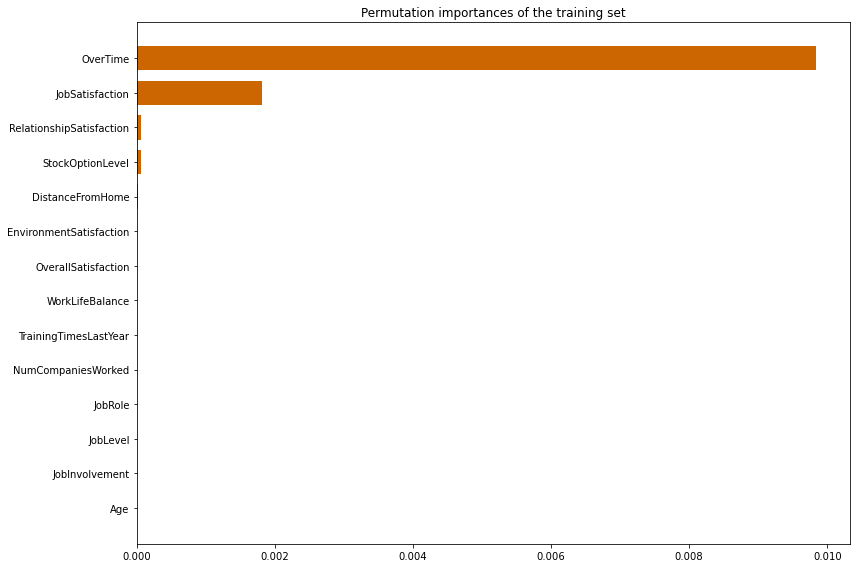



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.048003
OverTime                                           0.029349
JobSatisfaction                                    0.021947
EnvironmentSatisfaction                            0.011903
RelationshipSatisfaction                           0.010642
JobLevel                                           0.009847
Age                                                0.008960
WorkLifeBalance                                    0.007408
TrainingTimesLastYear                              -0.010026
OverallSatisfaction                                -0.010603
JobInvolvement                                     -0.015095
JobRole                                            -0.015700
NumCompaniesWorked                                 -0.019378
DistanceFromHome                                   -0.025978



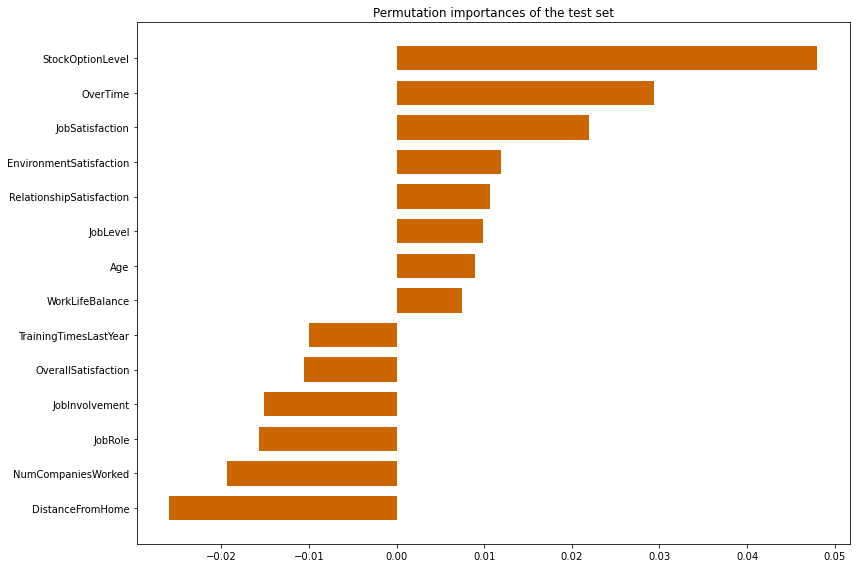



Confusion matrix


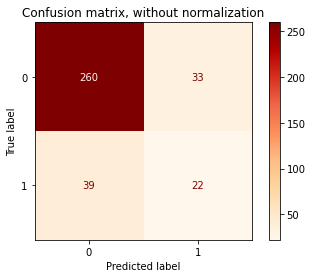

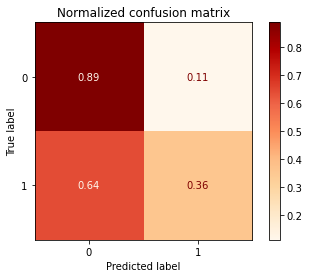


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       293
           1       0.40      0.36      0.38        61

    accuracy                           0.80       354
   macro avg       0.63      0.62      0.63       354
weighted avg       0.79      0.80      0.79       354


Metrics

Accuracy 0.7966101694915254
F1-score [0.87837838 0.37931034]
Precision [0.86956522 0.4       ]
Recall [0.88737201 0.36065574]
Roc_auc 0.6240138756783976


Roc curve



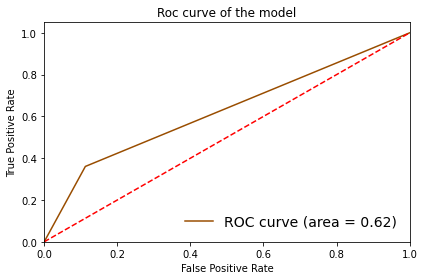


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.582208348756085
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


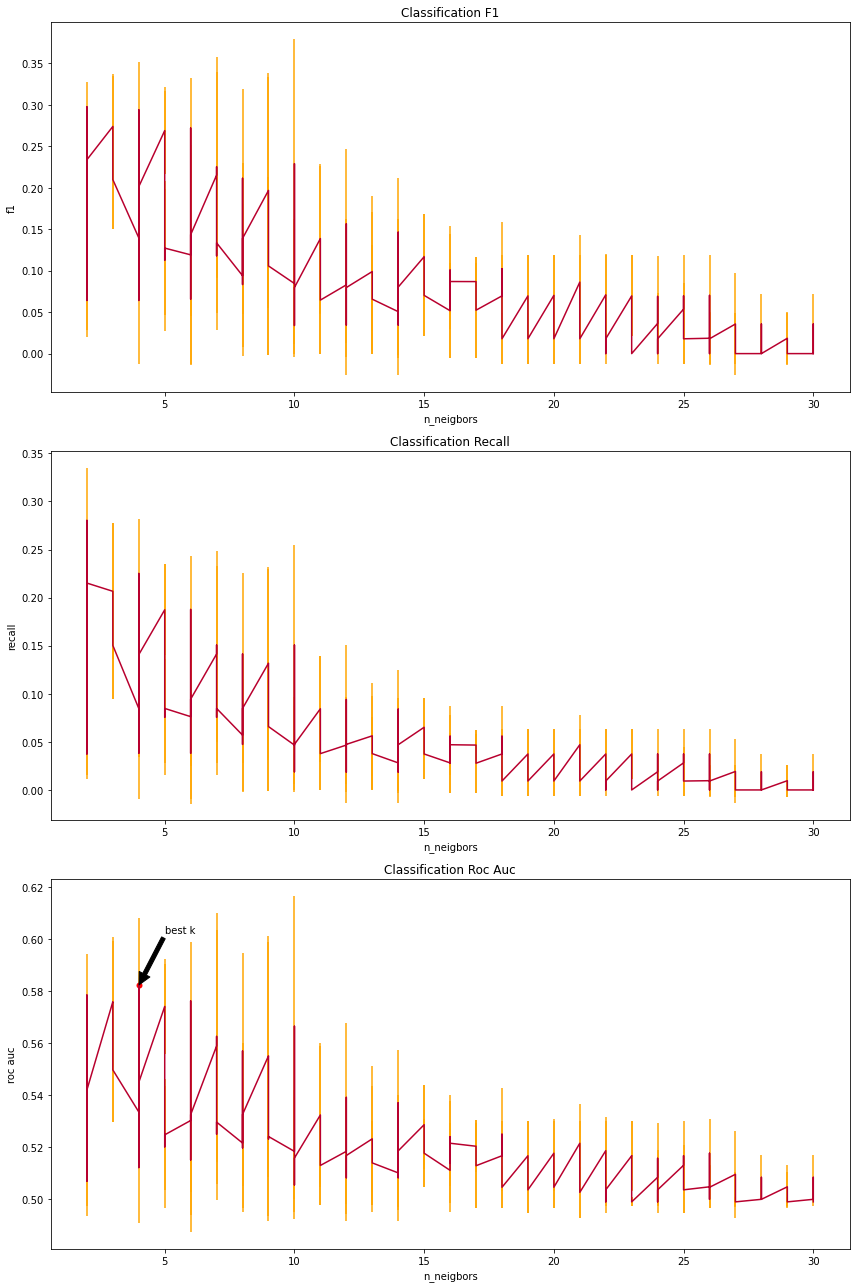



Permutation importances of the training set

OverTime                                           0.016649
RelationshipSatisfaction                           0.003579
JobSatisfaction                                    0.002242
EnvironmentSatisfaction                            0.001609
NumCompaniesWorked                                 0.001392
DistanceFromHome                                   0.001317
Age                                                0.000942
StockOptionLevel                                   0.000561
WorkLifeBalance                                    0.000344
JobInvolvement                                     0.000236
JobLevel                                           0.000059
JobRole                                            0.000007
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000



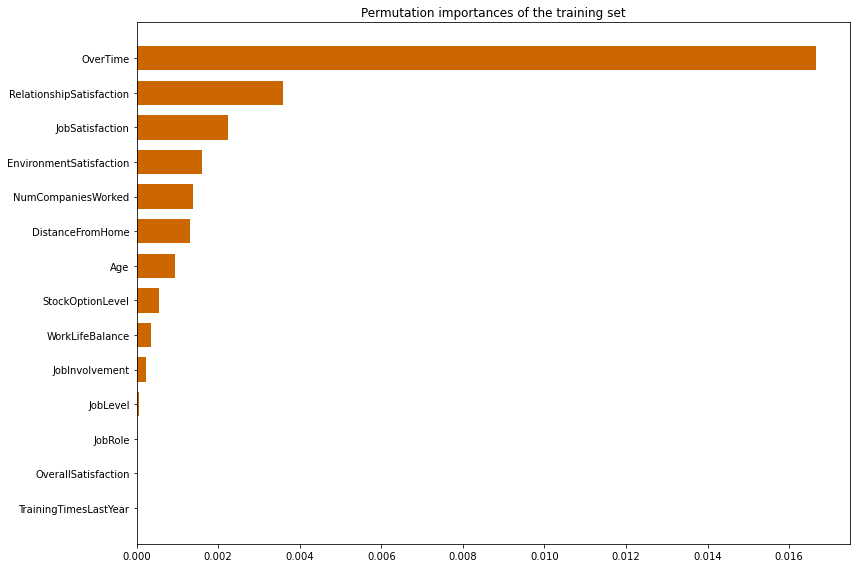



Predictions

Permutation importances of the test set

OverTime                                           0.062850
StockOptionLevel                                   0.033730
WorkLifeBalance                                    0.027665
Age                                                0.026261
JobSatisfaction                                    0.024082
RelationshipSatisfaction                           0.022990
JobLevel                                           0.012091
EnvironmentSatisfaction                            0.011257
JobRole                                            0.010979
JobInvolvement                                     0.010855
NumCompaniesWorked                                 0.003132
OverallSatisfaction                                -0.008616
DistanceFromHome                                   -0.014835
TrainingTimesLastYear                              -0.026042



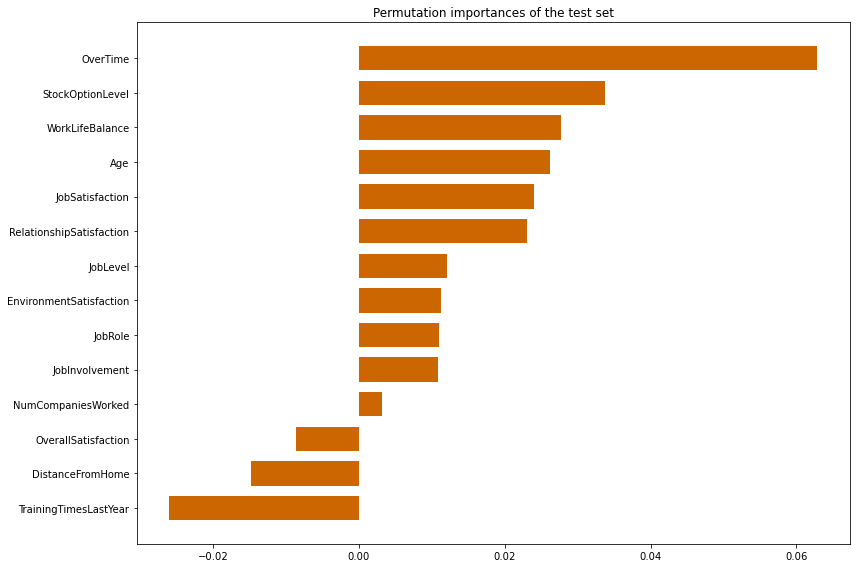



Confusion matrix


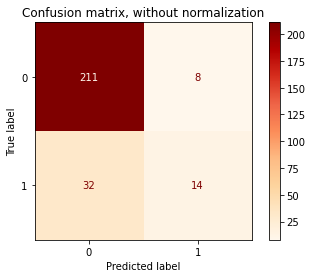

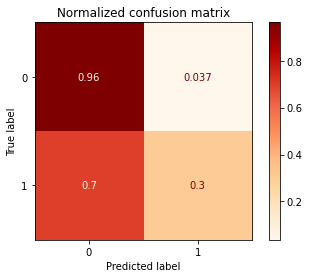


Classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       219
           1       0.64      0.30      0.41        46

    accuracy                           0.85       265
   macro avg       0.75      0.63      0.66       265
weighted avg       0.83      0.85      0.83       265


Metrics

Accuracy 0.8490566037735849
F1-score [0.91341991 0.41176471]
Precision [0.86831276 0.63636364]
Recall [0.96347032 0.30434783]
Roc_auc 0.6339090728608299


Roc curve



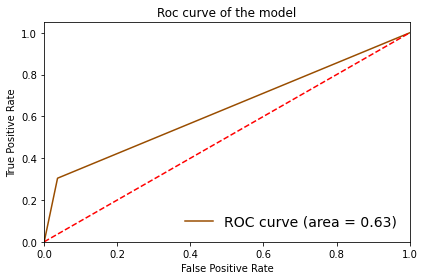


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6486503903373104
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


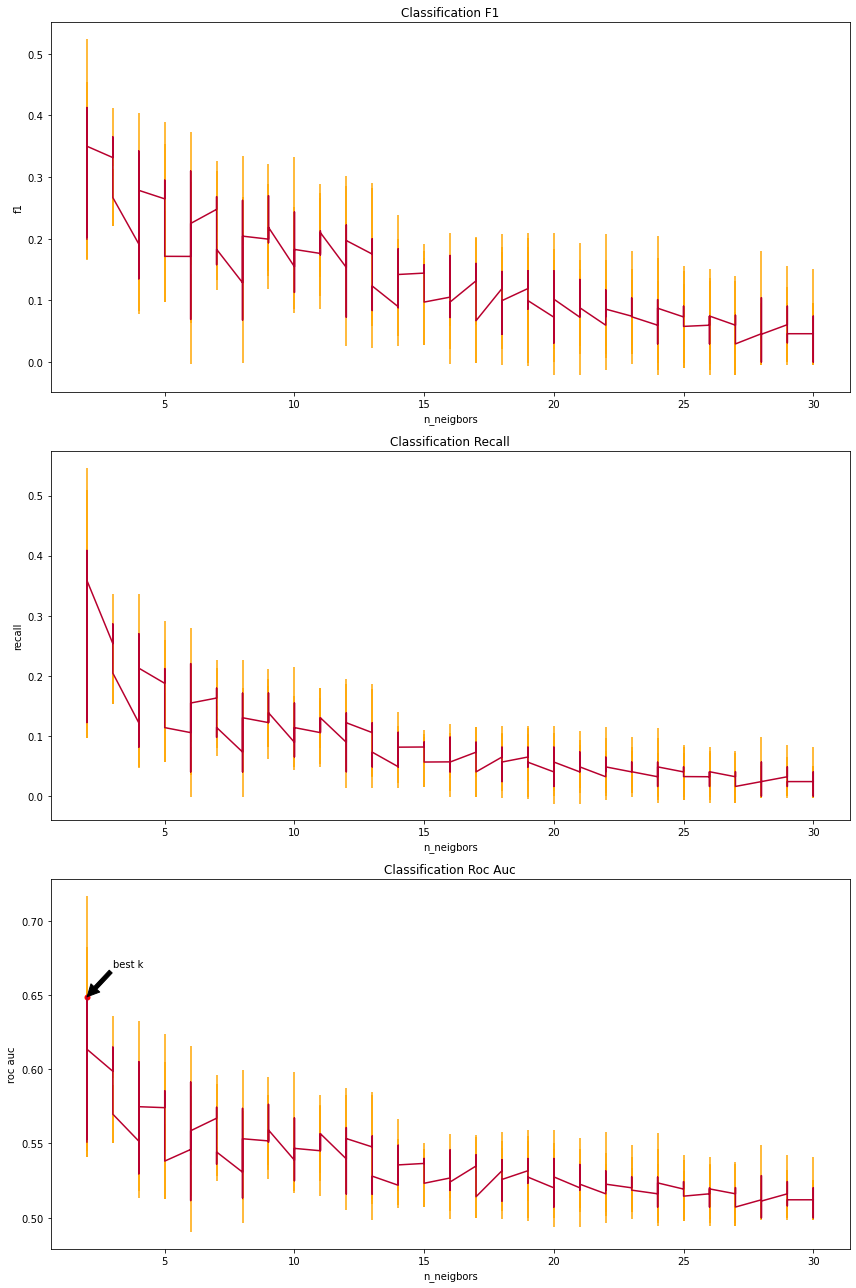



Permutation importances of the training set

OverTime                                           0.011557
RelationshipSatisfaction                           0.002910
JobSatisfaction                                    0.002858
DistanceFromHome                                   0.002766
Age                                                0.002734
EnvironmentSatisfaction                            0.000664
NumCompaniesWorked                                 0.000444
StockOptionLevel                                   0.000045
JobInvolvement                                     0.000001
WorkLifeBalance                                    0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000



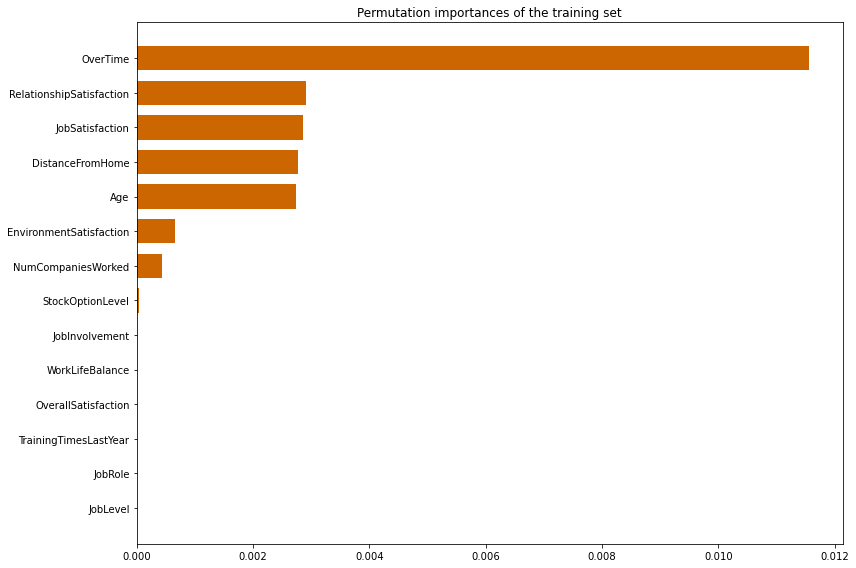



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.056275
WorkLifeBalance                                    0.036986
JobLevel                                           0.026403
OverTime                                           0.024768
JobSatisfaction                                    0.022647
JobInvolvement                                     0.004087
Age                                                -0.003922
TrainingTimesLastYear                              -0.007612
NumCompaniesWorked                                 -0.016571
JobRole                                            -0.023398
RelationshipSatisfaction                           -0.024050
DistanceFromHome                                   -0.025784
OverallSatisfaction                                -0.031595
EnvironmentSatisfaction                            -0.055247



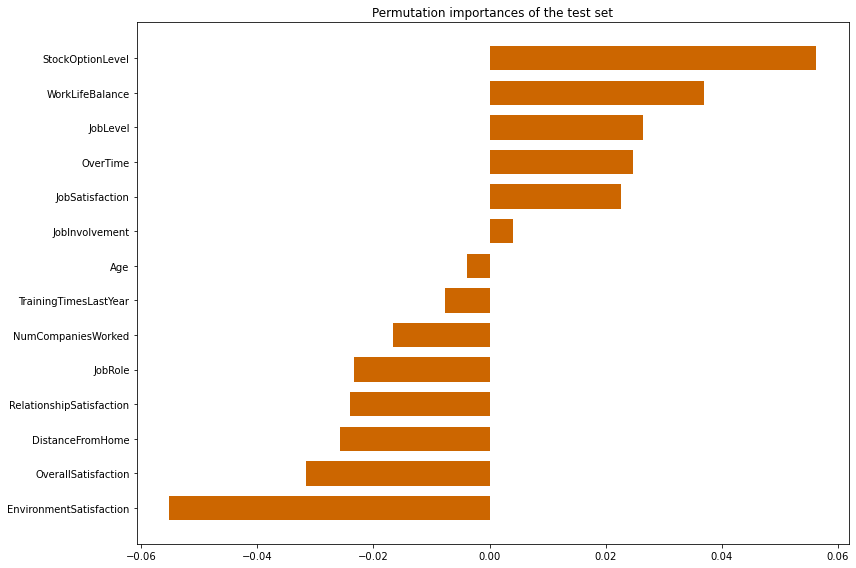



Confusion matrix


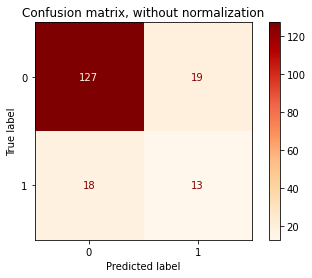

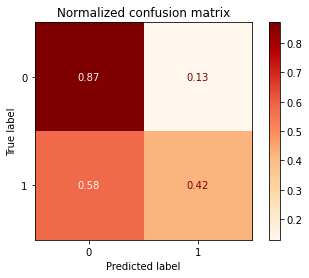


Classification report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       146
           1       0.41      0.42      0.41        31

    accuracy                           0.79       177
   macro avg       0.64      0.64      0.64       177
weighted avg       0.79      0.79      0.79       177


Metrics

Accuracy 0.7909604519774012
F1-score [0.87285223 0.41269841]
Precision [0.87586207 0.40625   ]
Recall [0.86986301 0.41935484]
Roc_auc 0.6446089262041539


Roc curve



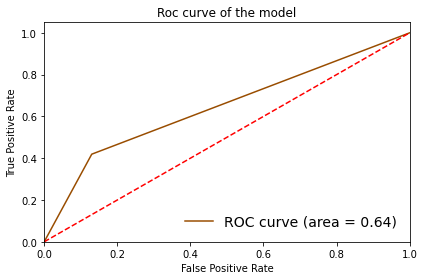


-------------------------------------------------------------------------------------------------------------



In [55]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.58898447982014
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


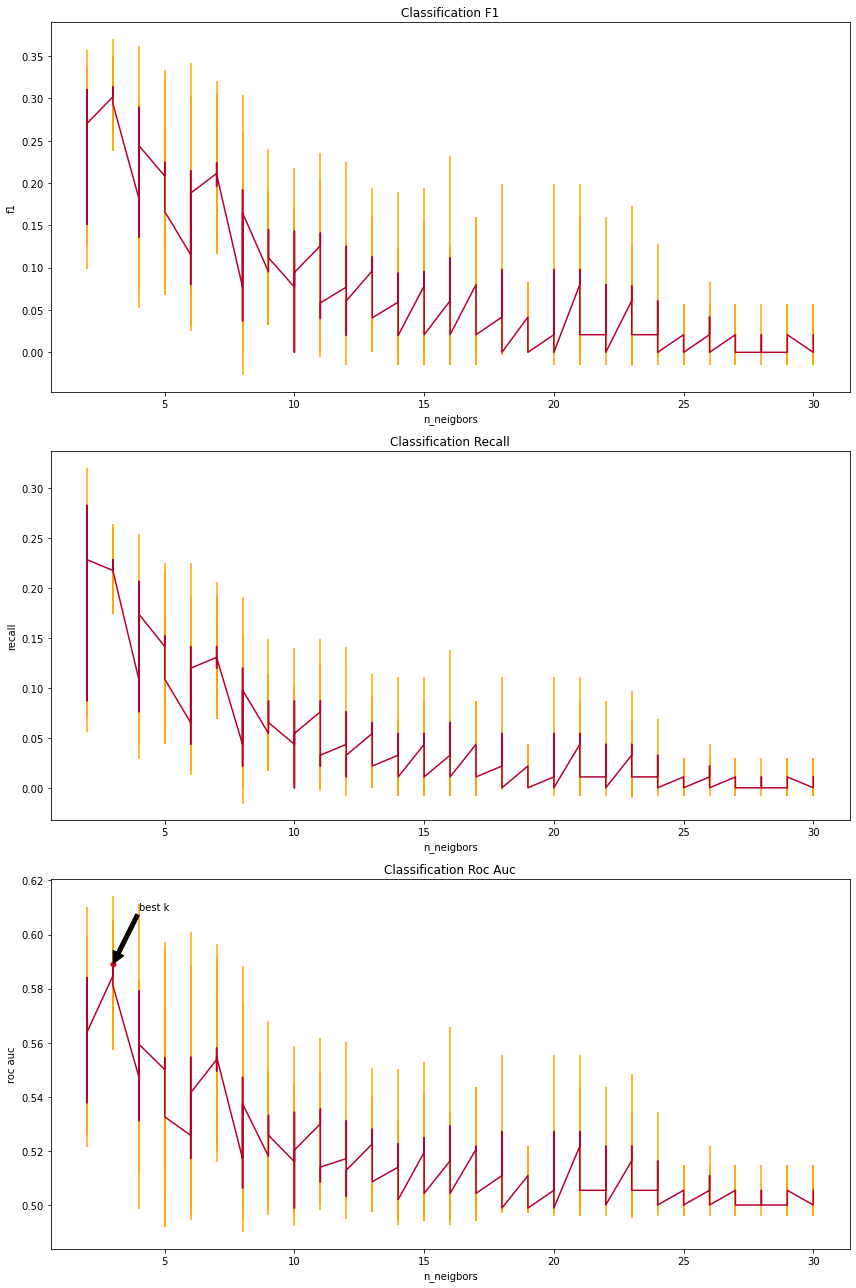



Permutation importances of the training set

OverTime                                           0.025469
StockOptionLevel                                   0.002038
DistanceFromHome                                   0.001271
NumCompaniesWorked                                 0.001112
RelationshipSatisfaction                           0.000948
JobSatisfaction                                    0.000699
Age                                                0.000373
EnvironmentSatisfaction                            0.000261
JobInvolvement                                     0.000025
WorkLifeBalance                                    0.000015
TrainingTimesLastYear                              0.000010
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000



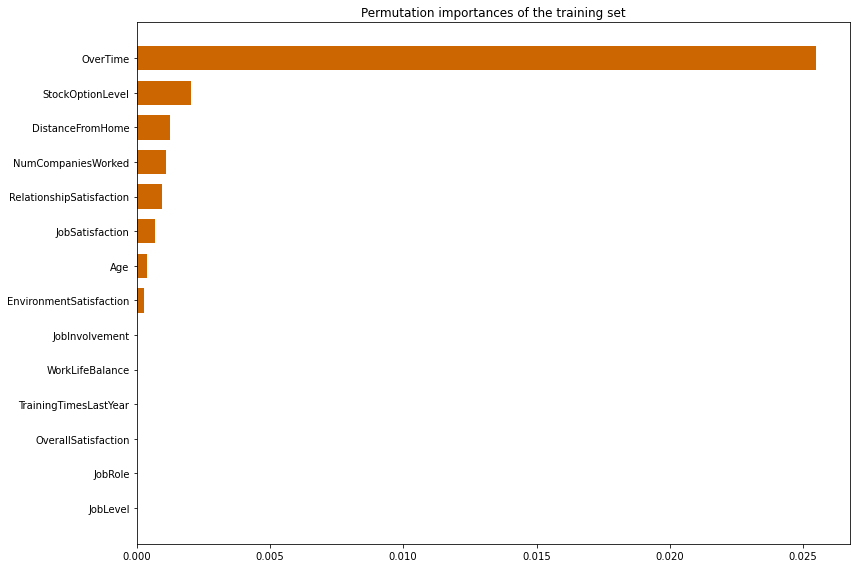



Predictions

Permutation importances of the test set

OverTime                                           0.025606
WorkLifeBalance                                    0.024554
StockOptionLevel                                   0.023203
Age                                                0.008186
JobSatisfaction                                    0.003108
OverallSatisfaction                                -0.005055
JobLevel                                           -0.005458
EnvironmentSatisfaction                            -0.005643
JobInvolvement                                     -0.012877
RelationshipSatisfaction                           -0.015868
JobRole                                            -0.026481
DistanceFromHome                                   -0.026744
NumCompaniesWorked                                 -0.029718
TrainingTimesLastYear                              -0.030222



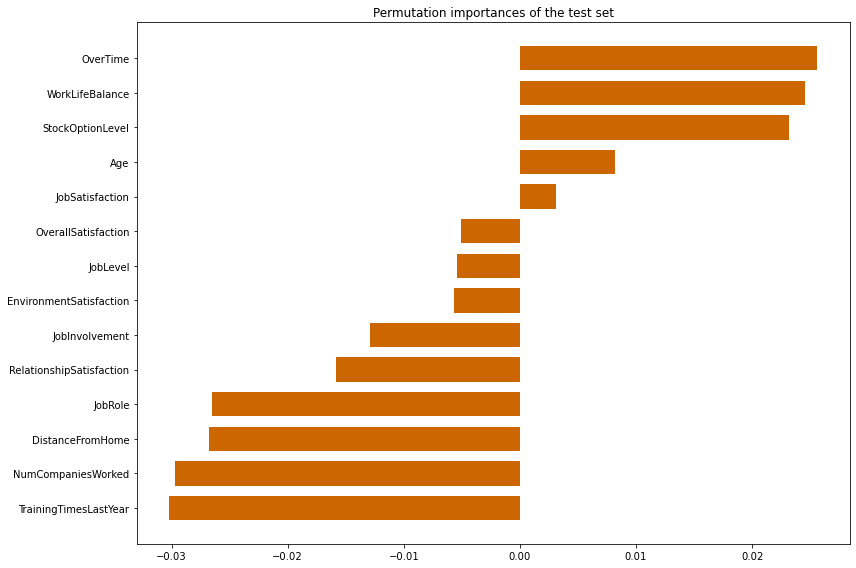



Confusion matrix


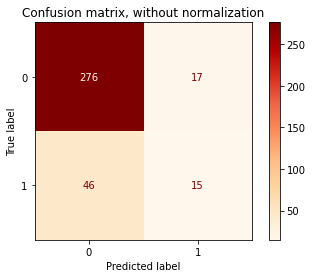

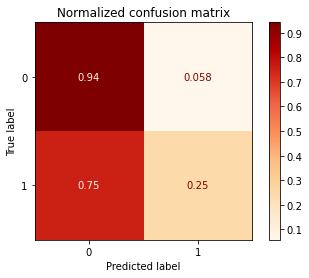


Classification report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       293
           1       0.47      0.25      0.32        61

    accuracy                           0.82       354
   macro avg       0.66      0.59      0.61       354
weighted avg       0.79      0.82      0.80       354


Metrics

Accuracy 0.8220338983050848
F1-score [0.89756098 0.32258065]
Precision [0.85714286 0.46875   ]
Recall [0.94197952 0.24590164]
Roc_auc 0.5939405807642814


Roc curve



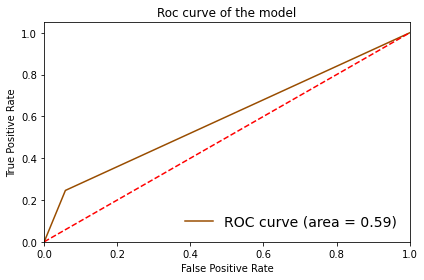


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5770651677855172
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


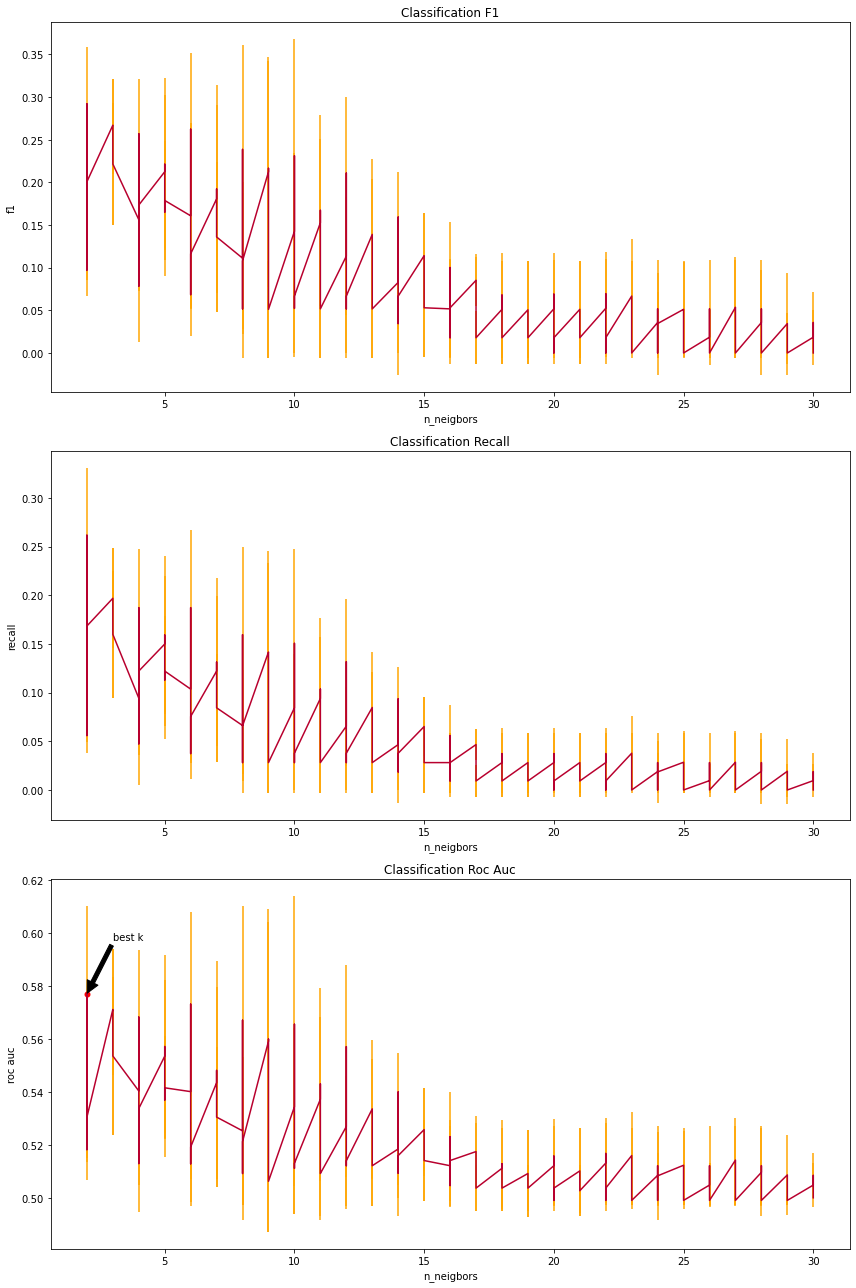



Permutation importances of the training set

OverTime                                           0.021247
Age                                                0.004706
StockOptionLevel                                   0.003232
NumCompaniesWorked                                 0.001627
DistanceFromHome                                   0.001295
EnvironmentSatisfaction                            0.000016
RelationshipSatisfaction                           0.000012
JobInvolvement                                     0.000002
WorkLifeBalance                                    0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000



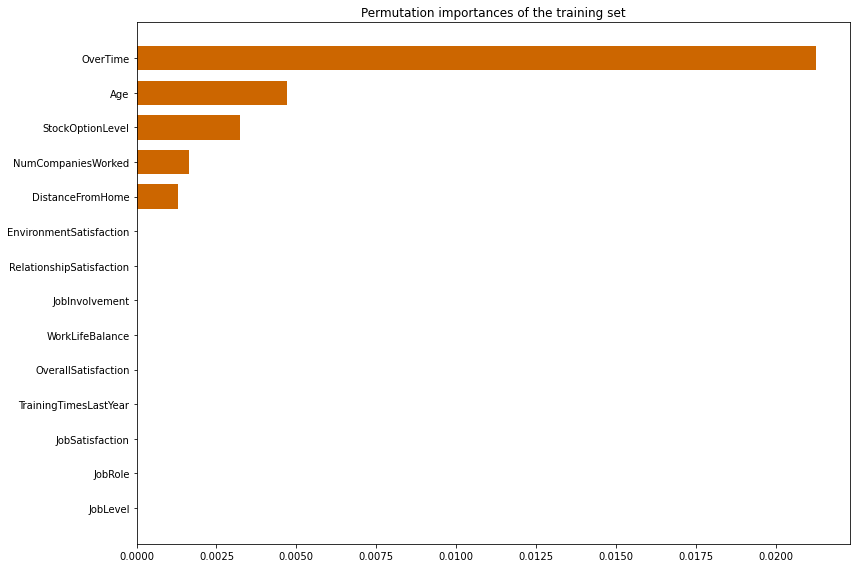



Predictions

Permutation importances of the test set

OverTime                                           0.054854
StockOptionLevel                                   0.046332
WorkLifeBalance                                    0.037368
JobSatisfaction                                    0.035721
Age                                                0.030494
RelationshipSatisfaction                           0.015997
JobRole                                            0.008189
JobLevel                                           0.007415
EnvironmentSatisfaction                            0.004075
OverallSatisfaction                                0.001241
NumCompaniesWorked                                 -0.001052
JobInvolvement                                     -0.021074
TrainingTimesLastYear                              -0.023759
DistanceFromHome                                   -0.038262



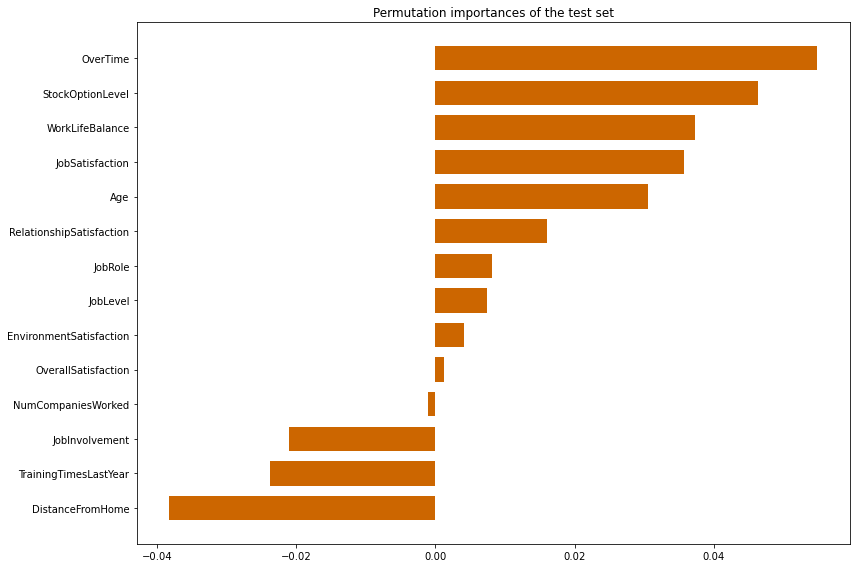



Confusion matrix


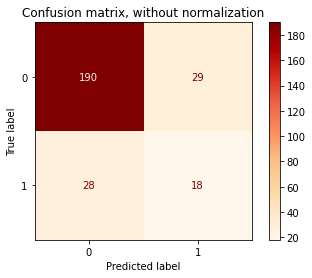

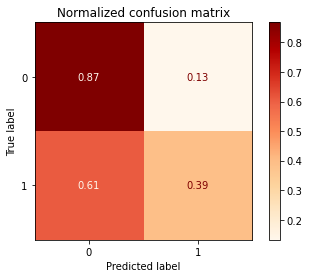


Classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       219
           1       0.38      0.39      0.39        46

    accuracy                           0.78       265
   macro avg       0.63      0.63      0.63       265
weighted avg       0.79      0.78      0.79       265


Metrics

Accuracy 0.7849056603773585
F1-score [0.86956522 0.38709677]
Precision [0.87155963 0.38297872]
Recall [0.86757991 0.39130435]
Roc_auc 0.629442128250943


Roc curve



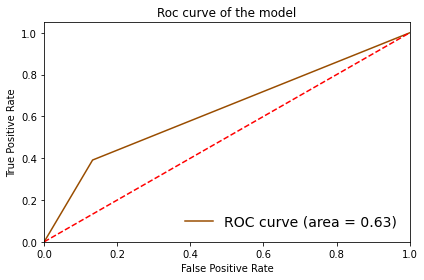


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6230832965090588
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


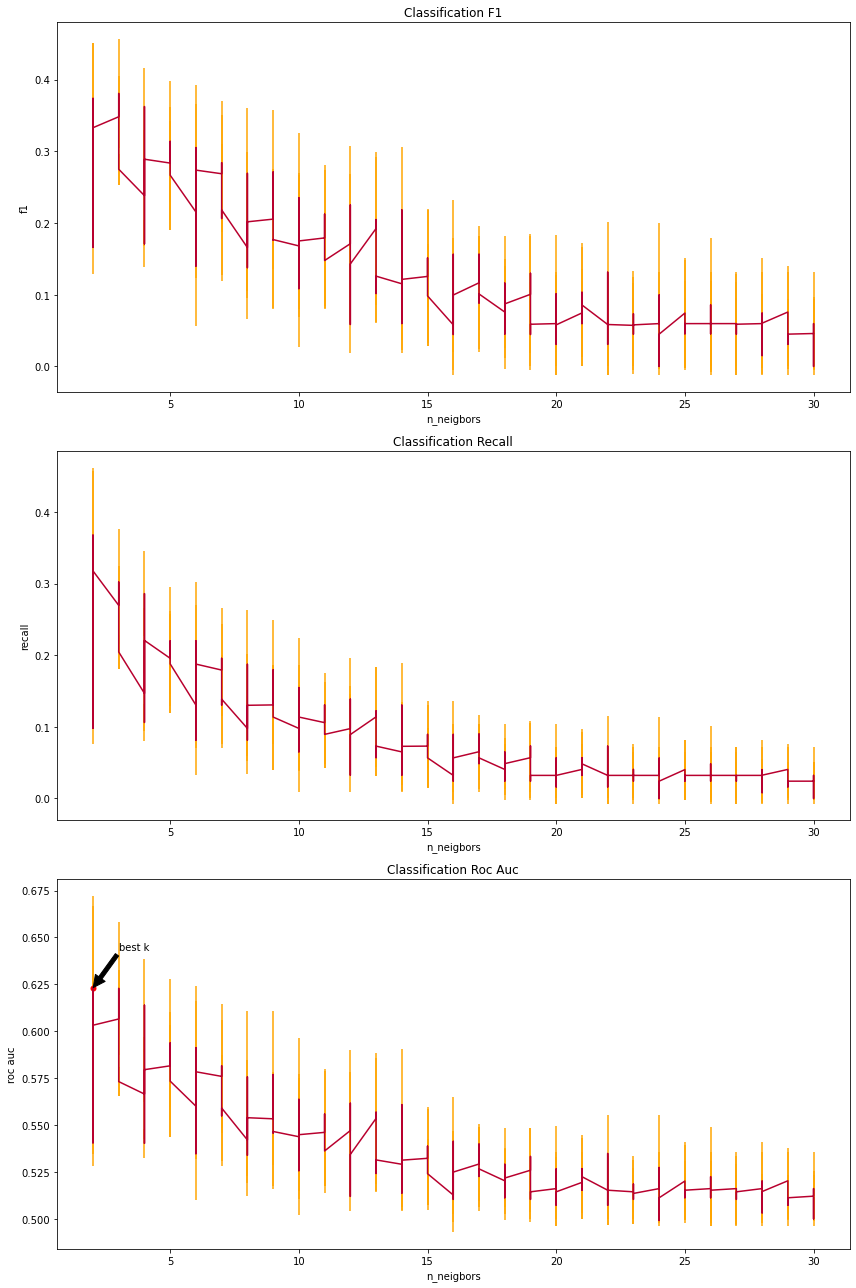



Permutation importances of the training set

OverTime                                           0.032265
StockOptionLevel                                   0.005310
Age                                                0.004133
NumCompaniesWorked                                 0.004060
DistanceFromHome                                   0.001634
EnvironmentSatisfaction                            0.000387
JobSatisfaction                                    0.000053
RelationshipSatisfaction                           0.000027
TrainingTimesLastYear                              0.000011
JobInvolvement                                     0.000001
JobLevel                                           0.000000
OverallSatisfaction                                0.000000
JobRole                                            0.000000
WorkLifeBalance                                    0.000000



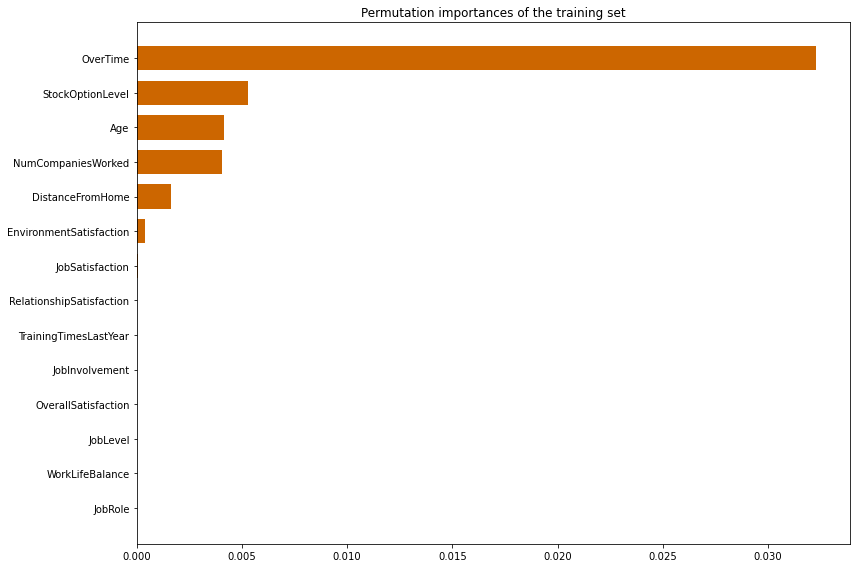



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.076757
OverTime                                           0.070935
JobSatisfaction                                    0.044189
WorkLifeBalance                                    0.030027
Age                                                0.015985
JobRole                                            -0.000817
DistanceFromHome                                   -0.007313
TrainingTimesLastYear                              -0.009180
OverallSatisfaction                                -0.010605
RelationshipSatisfaction                           -0.011025
JobLevel                                           -0.011500
JobInvolvement                                     -0.012384
NumCompaniesWorked                                 -0.019554
EnvironmentSatisfaction                            -0.033197



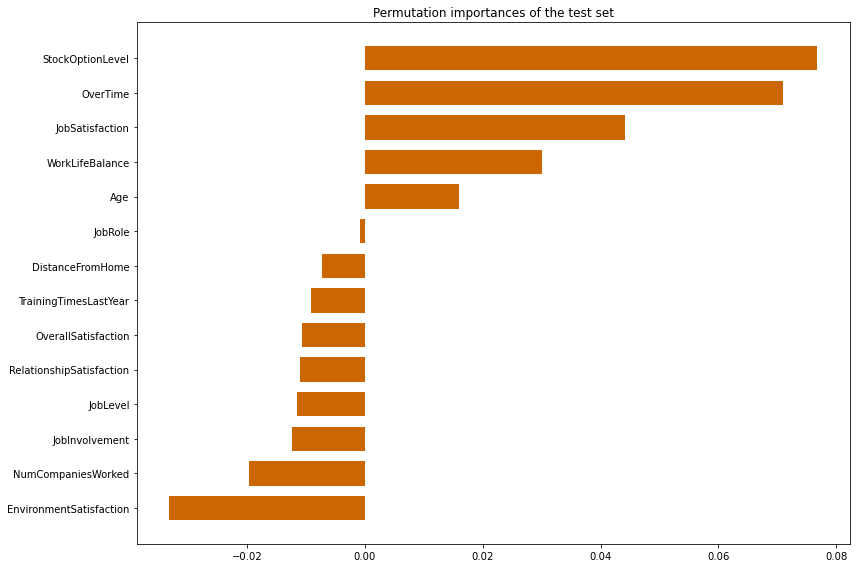



Confusion matrix


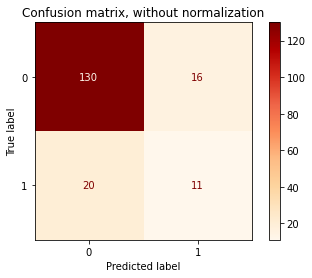

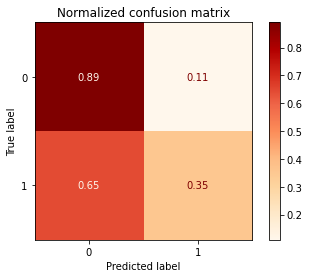


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       146
           1       0.41      0.35      0.38        31

    accuracy                           0.80       177
   macro avg       0.64      0.62      0.63       177
weighted avg       0.79      0.80      0.79       177


Metrics

Accuracy 0.7966101694915254
F1-score [0.87837838 0.37931034]
Precision [0.86666667 0.40740741]
Recall [0.89041096 0.35483871]
Roc_auc 0.6226248342907645


Roc curve



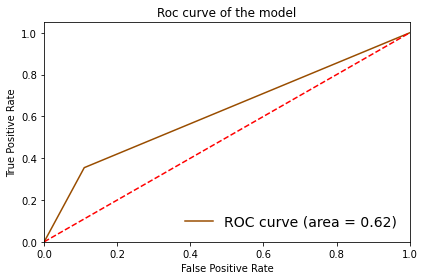


-------------------------------------------------------------------------------------------------------------



In [56]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5823924828661566
Best parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


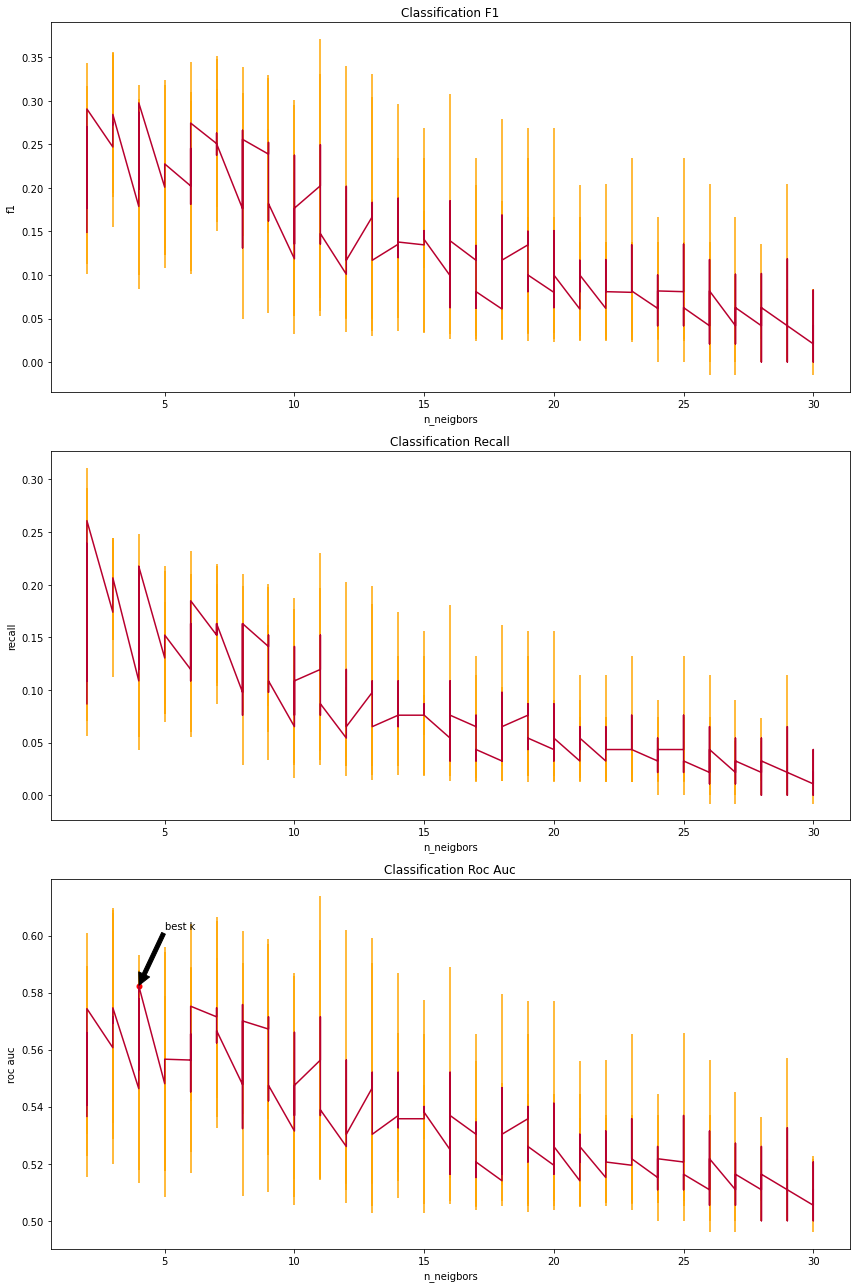



Permutation importances of the training set

TrainingTimesLastYear                              0.061123
NumCompaniesWorked                                 0.059749
StockOptionLevel                                   0.057559
JobRole                                            0.052215
JobLevel                                           0.048393
WorkLifeBalance                                    0.025451
JobInvolvement                                     0.013155
OverallSatisfaction                                0.010383
JobSatisfaction                                    0.007529
RelationshipSatisfaction                           0.005154
OverTime                                           0.005087
DistanceFromHome                                   0.003863
EnvironmentSatisfaction                            0.003564
Age                                                0.002288



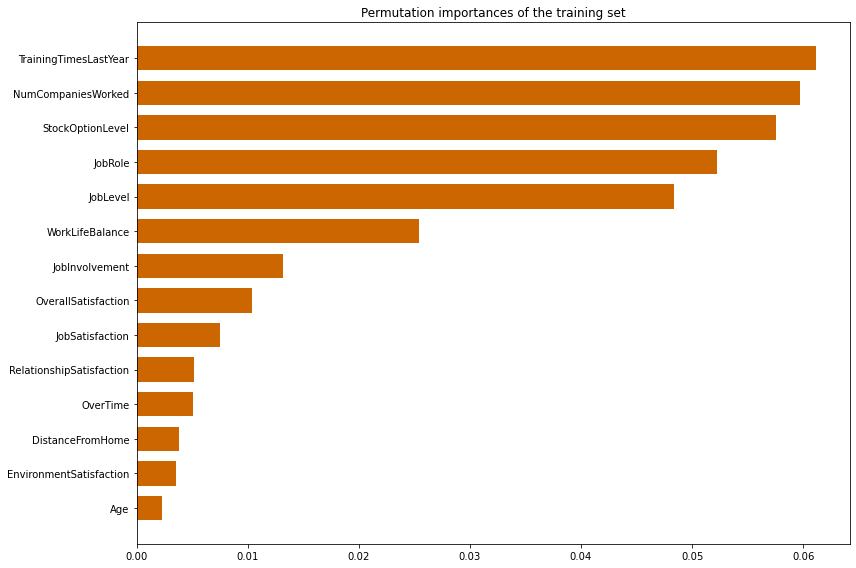



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.039803
OverallSatisfaction                                0.039632
NumCompaniesWorked                                 0.035956
JobRole                                            0.032695
JobLevel                                           0.022249
WorkLifeBalance                                    0.014662
Age                                                0.013954
JobInvolvement                                     0.011601
EnvironmentSatisfaction                            0.005934
OverTime                                           0.002148
JobSatisfaction                                    -0.005388
RelationshipSatisfaction                           -0.009067
TrainingTimesLastYear                              -0.012502
DistanceFromHome                                   -0.013397



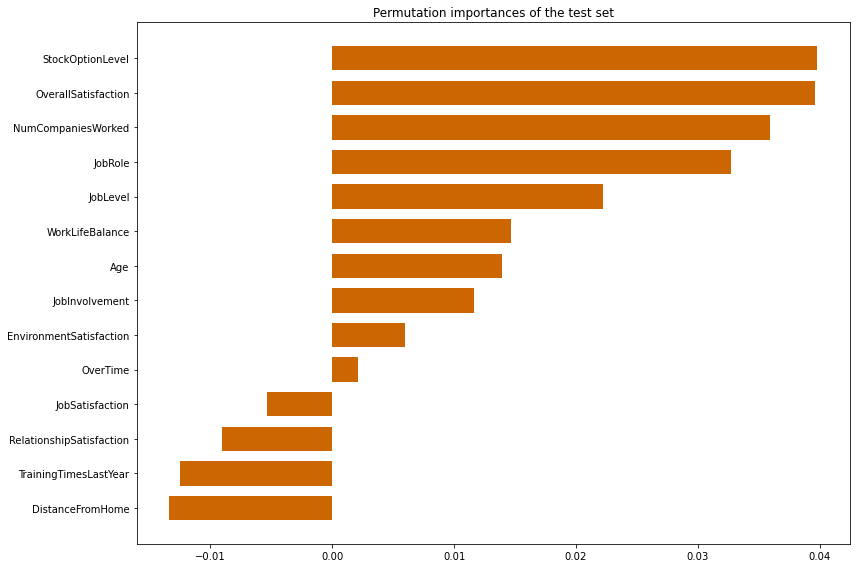



Confusion matrix


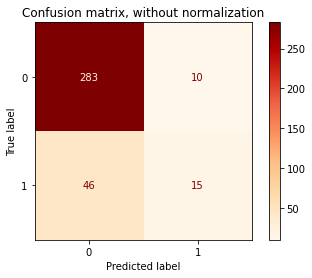

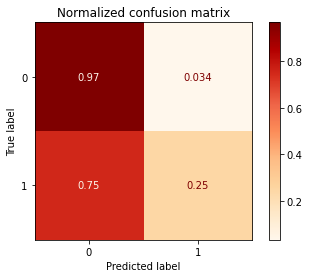


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       293
           1       0.60      0.25      0.35        61

    accuracy                           0.84       354
   macro avg       0.73      0.61      0.63       354
weighted avg       0.82      0.84      0.81       354


Metrics

Accuracy 0.8418079096045198
F1-score [0.90996785 0.34883721]
Precision [0.86018237 0.6       ]
Recall [0.96587031 0.24590164]
Roc_auc 0.605885973255749


Roc curve



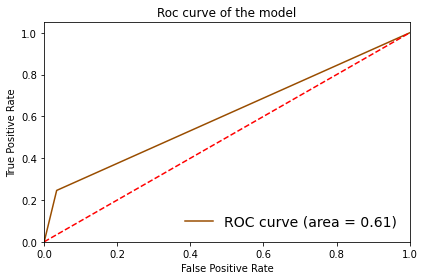


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5776644643678355
Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier()

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


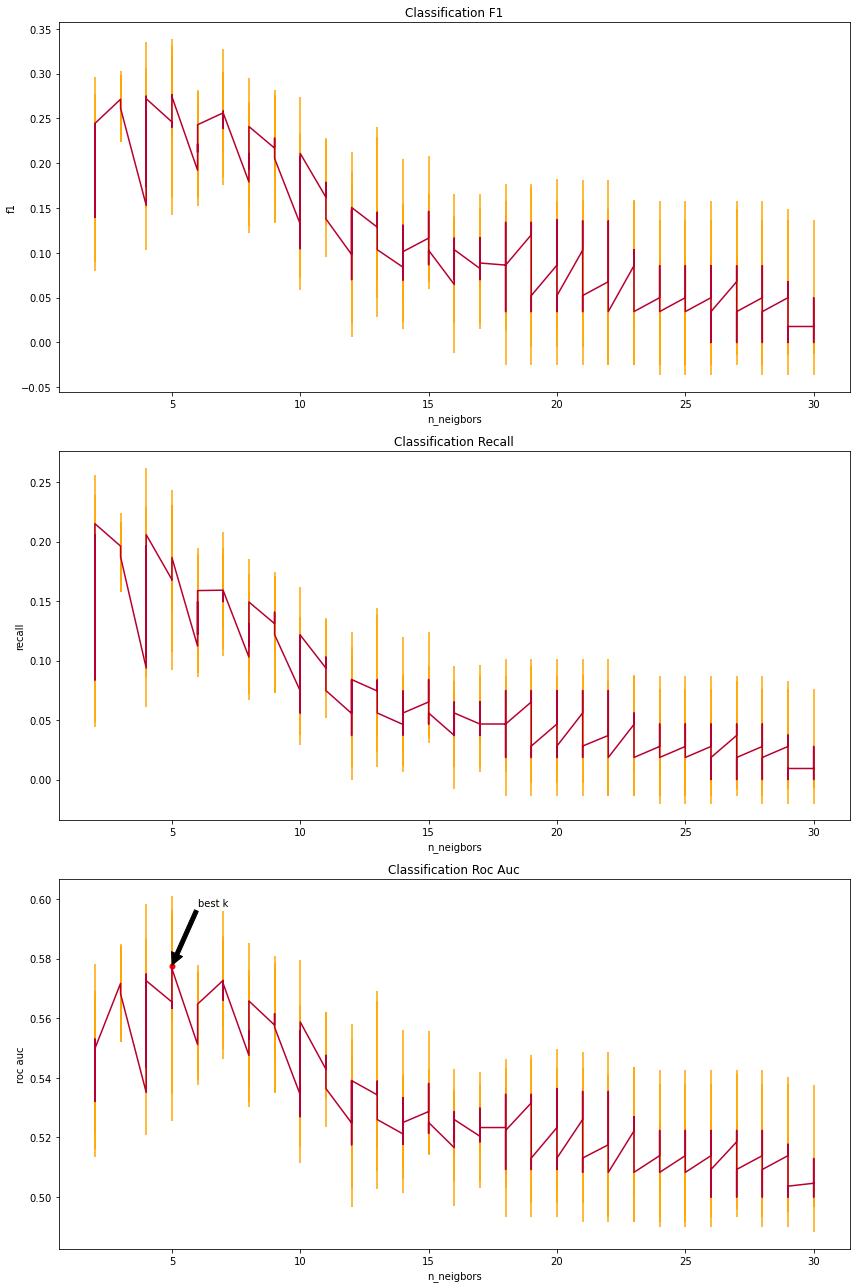



Permutation importances of the training set

StockOptionLevel                                   0.050040
JobLevel                                           0.047204
JobRole                                            0.043040
NumCompaniesWorked                                 0.035171
TrainingTimesLastYear                              0.032287
WorkLifeBalance                                    0.021693
OverTime                                           0.007435
Age                                                0.007396
OverallSatisfaction                                0.005969
EnvironmentSatisfaction                            0.005401
JobSatisfaction                                    0.004079
JobInvolvement                                     0.001934
RelationshipSatisfaction                           -0.000108
DistanceFromHome                                   -0.001568



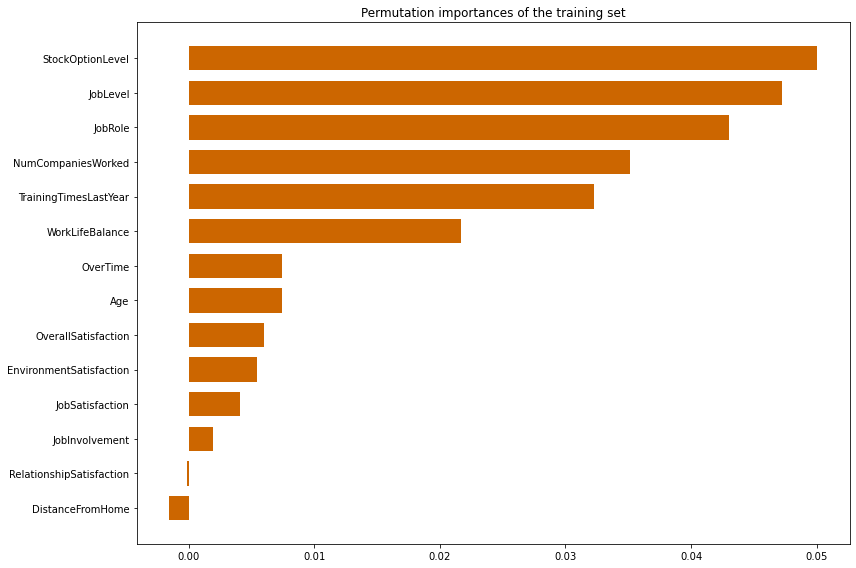



Predictions

Permutation importances of the test set

NumCompaniesWorked                                 0.058244
StockOptionLevel                                   0.056179
JobRole                                            0.048610
WorkLifeBalance                                    0.040312
OverallSatisfaction                                0.039796
JobLevel                                           0.035949
JobInvolvement                                     0.028018
JobSatisfaction                                    0.008993
OverTime                                           0.007127
TrainingTimesLastYear                              0.004596
EnvironmentSatisfaction                            0.003092
Age                                                0.002943
RelationshipSatisfaction                           -0.000114
DistanceFromHome                                   -0.021630



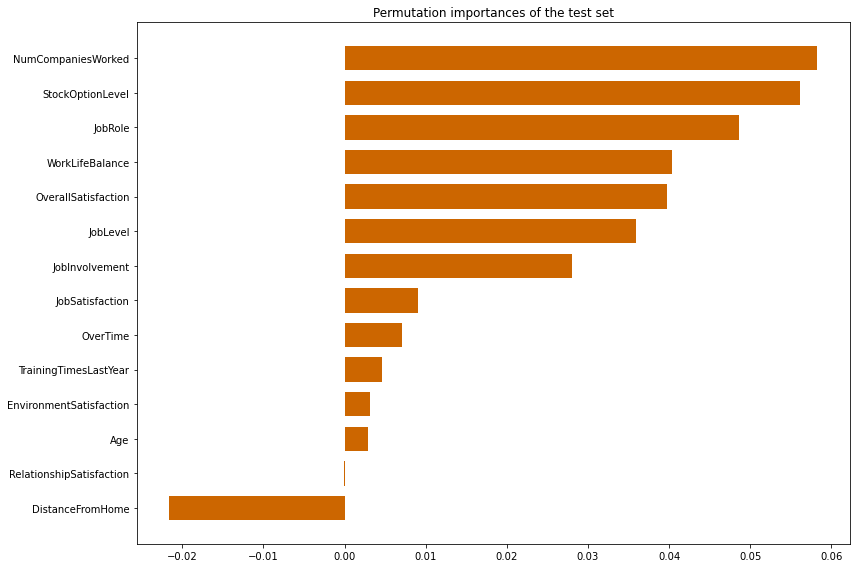



Confusion matrix


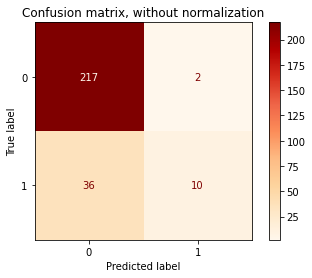

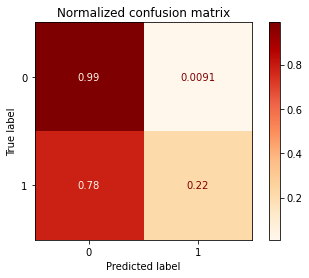


Classification report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       219
           1       0.83      0.22      0.34        46

    accuracy                           0.86       265
   macro avg       0.85      0.60      0.63       265
weighted avg       0.85      0.86      0.82       265


Metrics

Accuracy 0.8566037735849057
F1-score [0.91949153 0.34482759]
Precision [0.85770751 0.83333333]
Recall [0.99086758 0.2173913 ]
Roc_auc 0.604129442128251


Roc curve



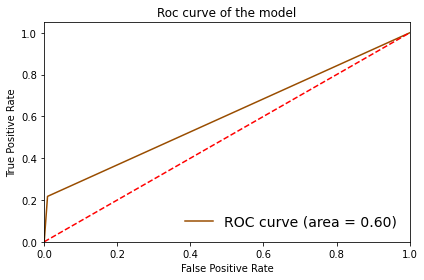


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6107048166151128
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


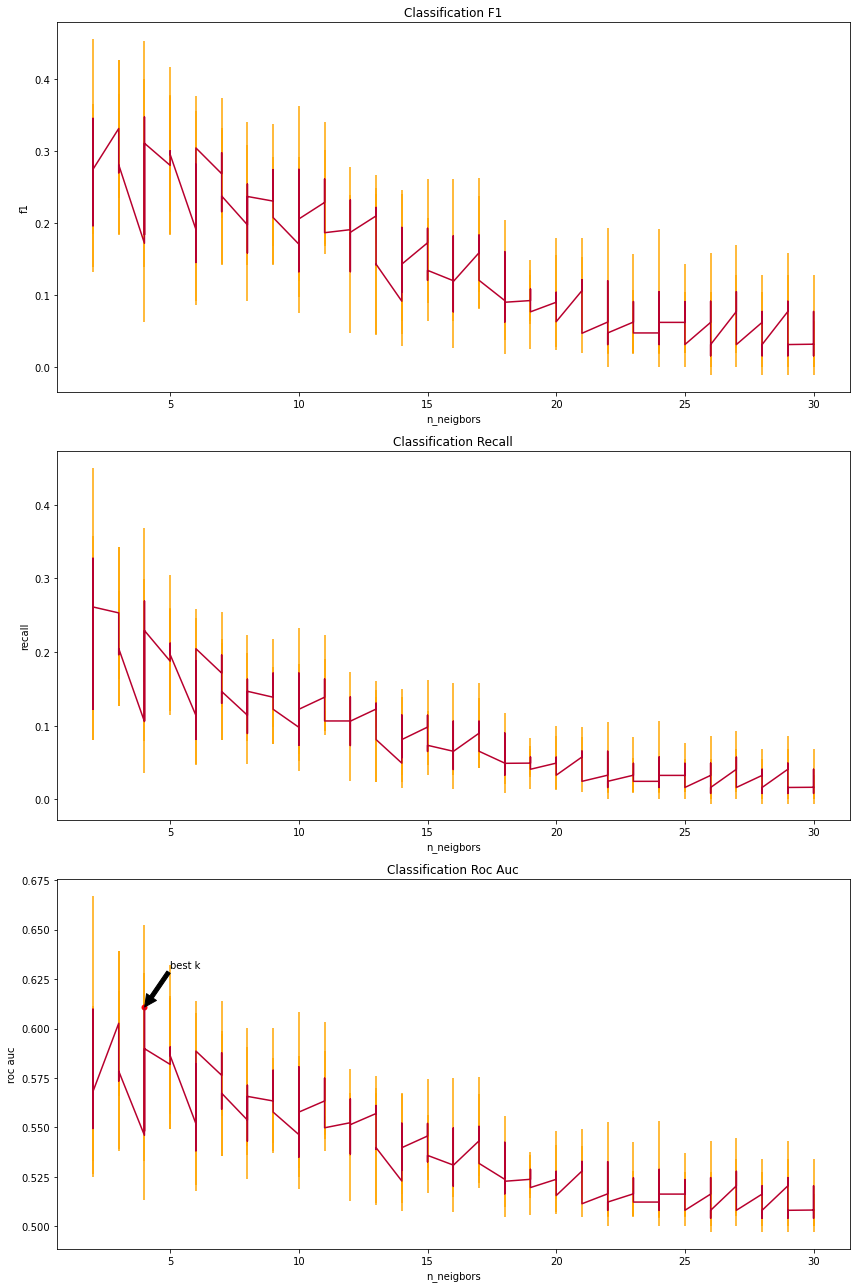



Permutation importances of the training set

NumCompaniesWorked                                 0.003893
StockOptionLevel                                   0.003587
TrainingTimesLastYear                              0.002553
JobRole                                            0.001489
JobLevel                                           0.001220
WorkLifeBalance                                    0.001141
JobInvolvement                                     0.000487
JobSatisfaction                                    0.000284
RelationshipSatisfaction                           0.000213
DistanceFromHome                                   0.000205
Age                                                0.000160
OverTime                                           0.000146
OverallSatisfaction                                0.000088
EnvironmentSatisfaction                            0.000073



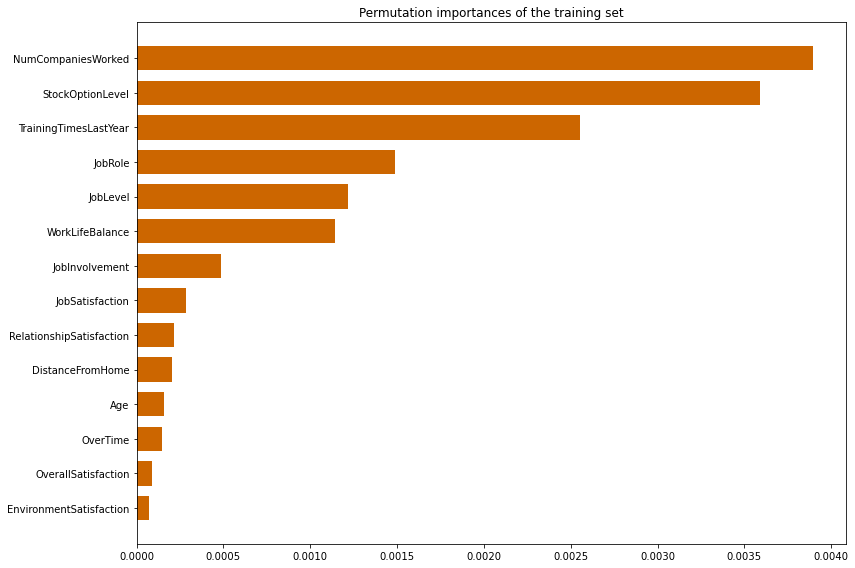



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.065798
WorkLifeBalance                                    0.051094
OverTime                                           0.041041
NumCompaniesWorked                                 0.032026
JobLevel                                           0.031949
JobRole                                            0.027309
EnvironmentSatisfaction                            0.022614
JobSatisfaction                                    0.017433
JobInvolvement                                     0.009523
RelationshipSatisfaction                           0.004010
OverallSatisfaction                                0.002530
DistanceFromHome                                   -0.002563
TrainingTimesLastYear                              -0.014848
Age                                                -0.017985



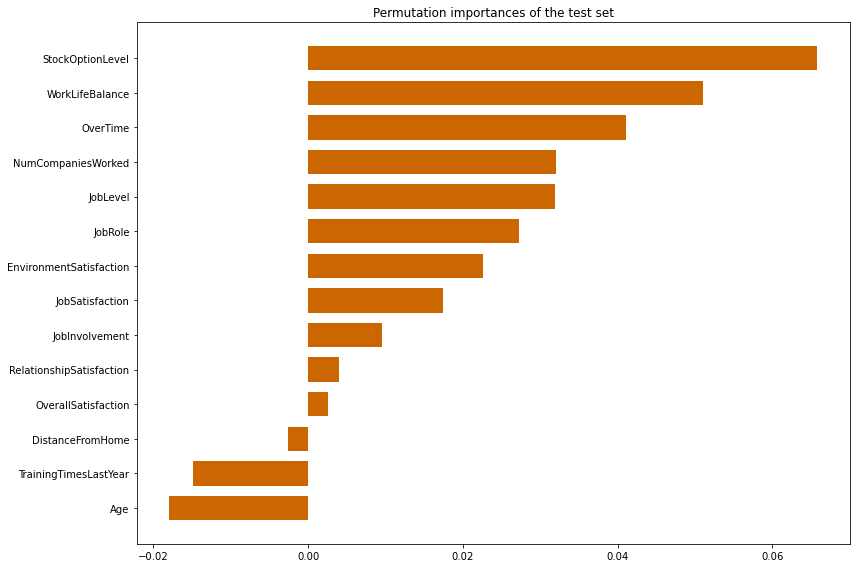



Confusion matrix


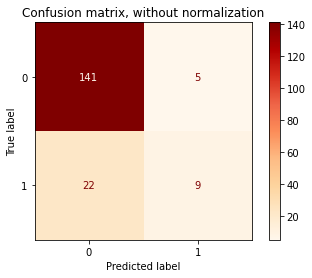

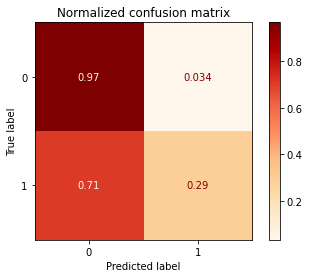


Classification report
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       146
           1       0.64      0.29      0.40        31

    accuracy                           0.85       177
   macro avg       0.75      0.63      0.66       177
weighted avg       0.83      0.85      0.82       177


Metrics

Accuracy 0.847457627118644
F1-score [0.91262136 0.4       ]
Precision [0.86503067 0.64285714]
Recall [0.96575342 0.29032258]
Roc_auc 0.6280380026513477


Roc curve



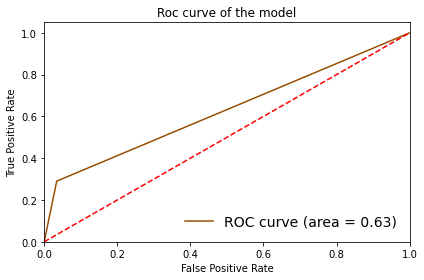


-------------------------------------------------------------------------------------------------------------



In [57]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5878272654748522
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


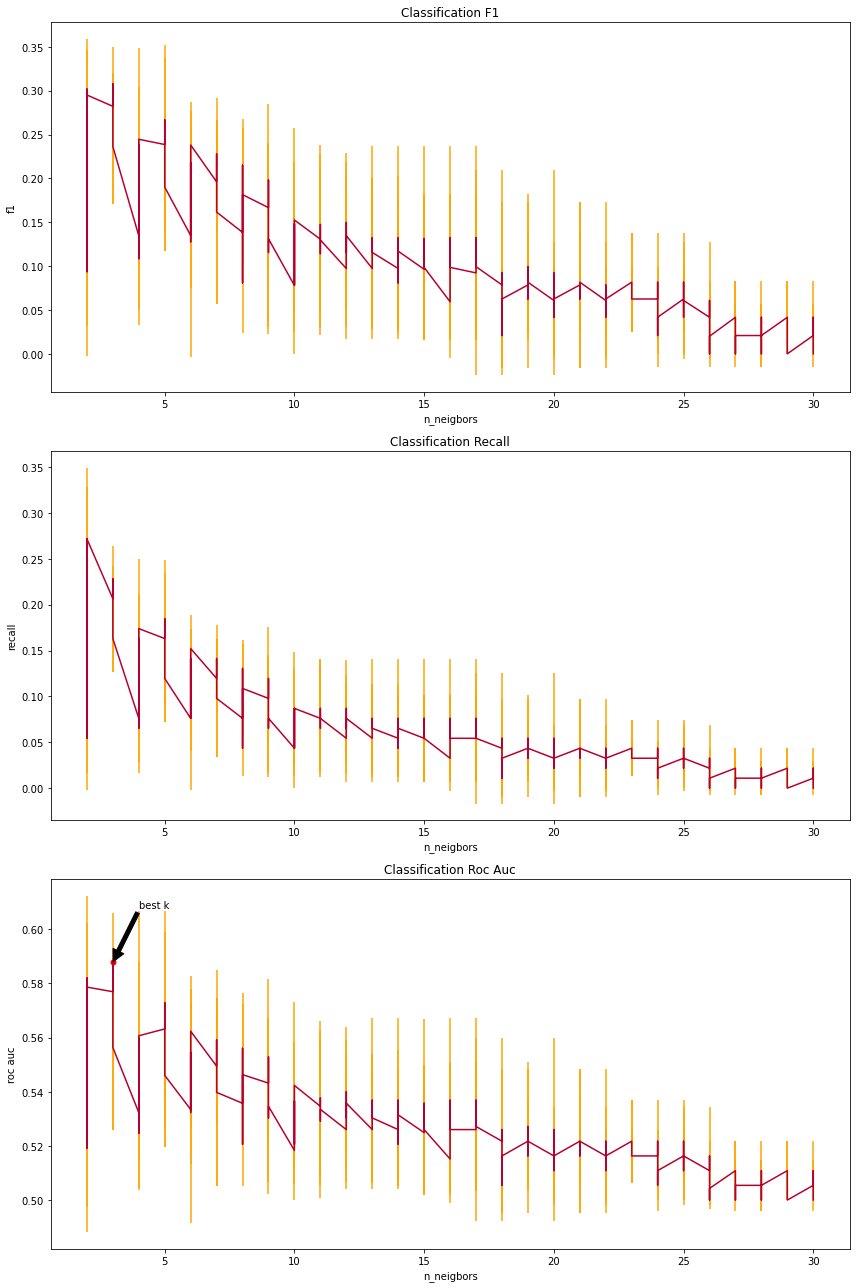



Permutation importances of the training set

OverTime                                           0.001915
WorkLifeBalance                                    0.000386
DistanceFromHome                                   0.000234
StockOptionLevel                                   0.000229
RelationshipSatisfaction                           0.000206
JobSatisfaction                                    0.000194
NumCompaniesWorked                                 0.000154
JobInvolvement                                     0.000102
Age                                                0.000099
EnvironmentSatisfaction                            0.000085
TrainingTimesLastYear                              0.000042
JobLevel                                           0.000010
JobRole                                            0.000000
OverallSatisfaction                                0.000000



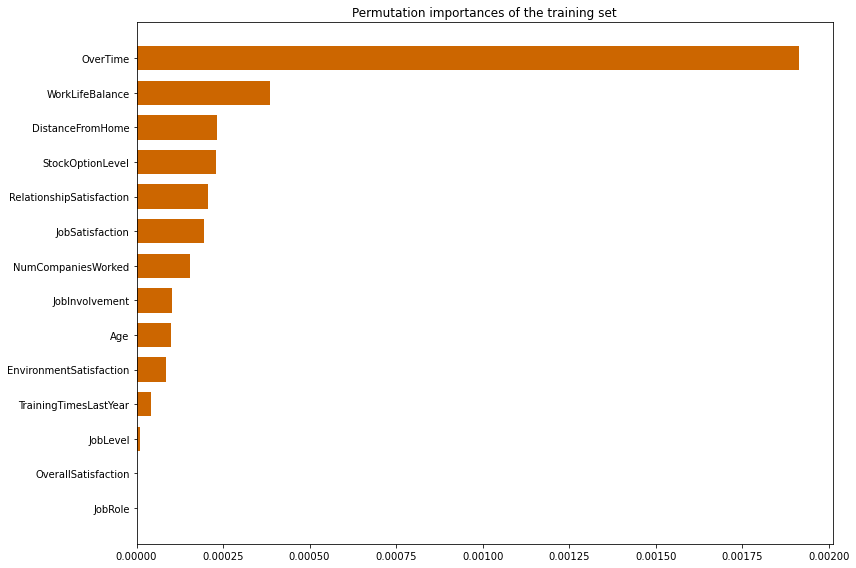



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.023454
EnvironmentSatisfaction                            0.017787
OverTime                                           0.009109
Age                                                0.007380
JobRole                                            0.003584
JobLevel                                           -0.001256
WorkLifeBalance                                    -0.003726
OverallSatisfaction                                -0.005223
DistanceFromHome                                   -0.005542
JobSatisfaction                                    -0.012250
NumCompaniesWorked                                 -0.020369
JobInvolvement                                     -0.023012
TrainingTimesLastYear                              -0.024685
RelationshipSatisfaction                           -0.028926



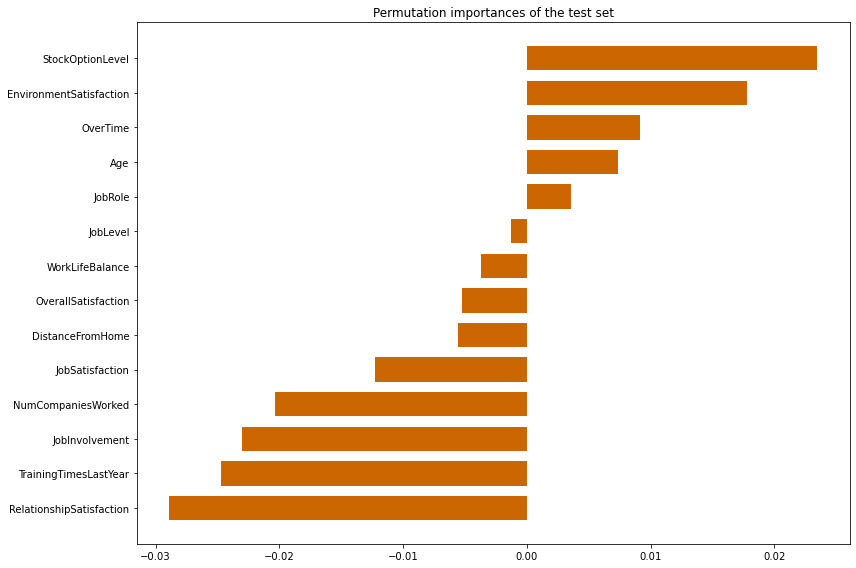



Confusion matrix


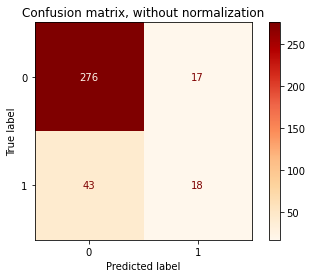

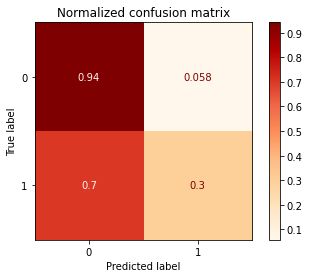


Classification report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       293
           1       0.51      0.30      0.37        61

    accuracy                           0.83       354
   macro avg       0.69      0.62      0.64       354
weighted avg       0.80      0.83      0.81       354


Metrics

Accuracy 0.8305084745762712
F1-score [0.90196078 0.375     ]
Precision [0.86520376 0.51428571]
Recall [0.94197952 0.29508197]
Roc_auc 0.6185307446987075


Roc curve



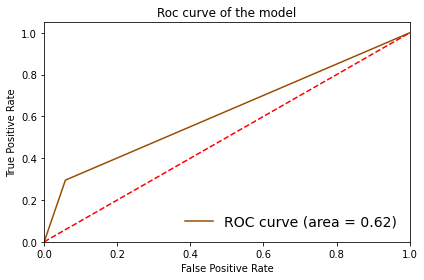


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.601470883597483
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


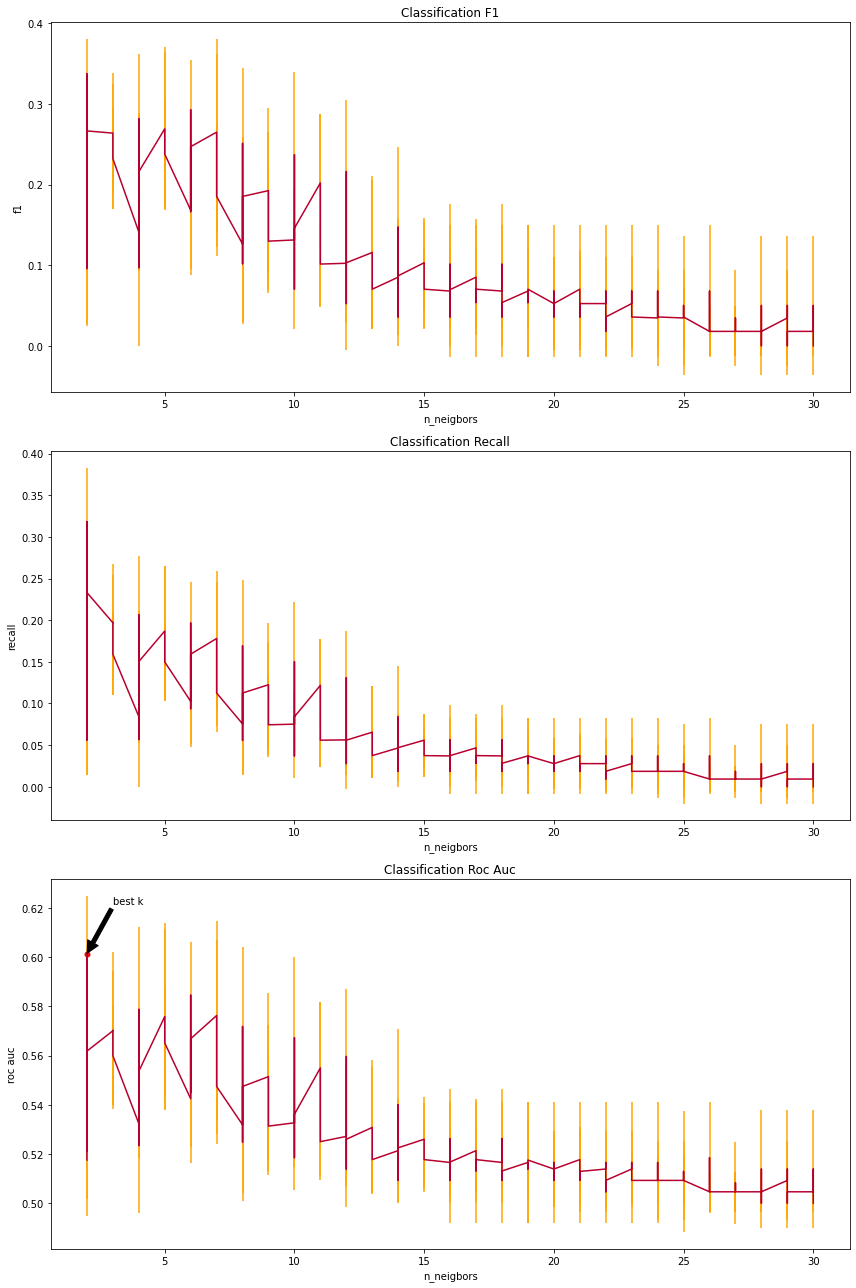



Permutation importances of the training set

StockOptionLevel                                   0.002024
OverTime                                           0.000843
JobInvolvement                                     0.000035
DistanceFromHome                                   0.000016
TrainingTimesLastYear                              0.000004
Age                                                0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
NumCompaniesWorked                                 0.000000
OverallSatisfaction                                0.000000
RelationshipSatisfaction                           0.000000
WorkLifeBalance                                    0.000000



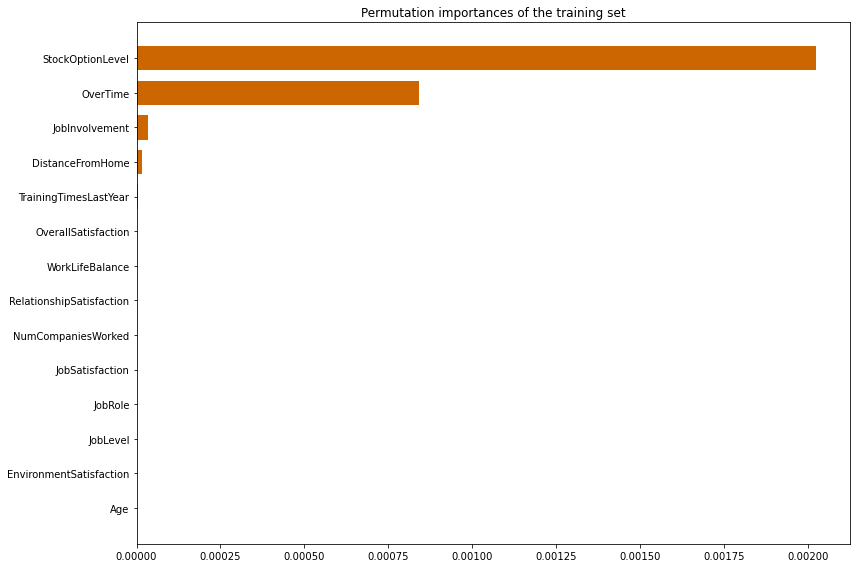



Predictions

Permutation importances of the test set

OverTime                                           0.048094
StockOptionLevel                                   0.030053
WorkLifeBalance                                    0.029090
JobSatisfaction                                    0.021645
OverallSatisfaction                                0.012160
JobInvolvement                                     0.011490
JobLevel                                           0.007877
JobRole                                            -0.000844
DistanceFromHome                                   -0.001906
NumCompaniesWorked                                 -0.002372
Age                                                -0.006616
RelationshipSatisfaction                           -0.007832
EnvironmentSatisfaction                            -0.019257
TrainingTimesLastYear                              -0.022459



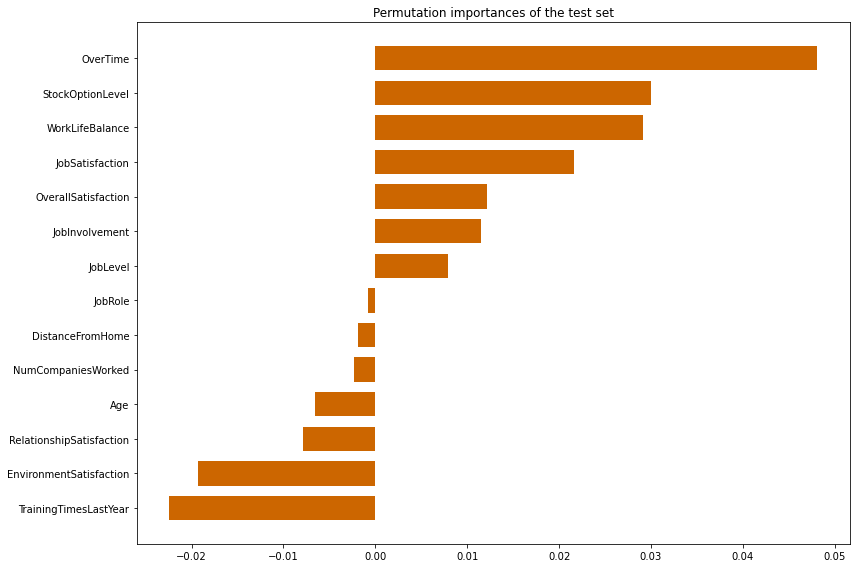



Confusion matrix


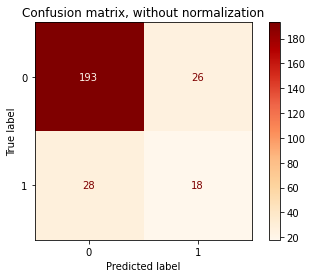

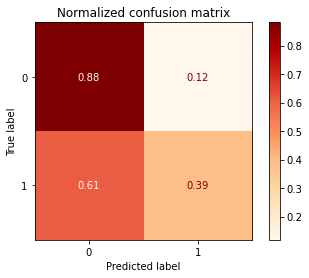


Classification report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       219
           1       0.41      0.39      0.40        46

    accuracy                           0.80       265
   macro avg       0.64      0.64      0.64       265
weighted avg       0.79      0.80      0.79       265


Metrics

Accuracy 0.7962264150943397
F1-score [0.87727273 0.4       ]
Precision [0.87330317 0.40909091]
Recall [0.88127854 0.39130435]
Roc_auc 0.6362914433194361


Roc curve



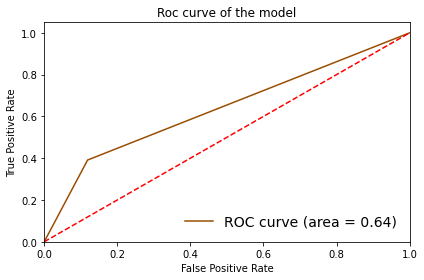


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6296711592281632
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


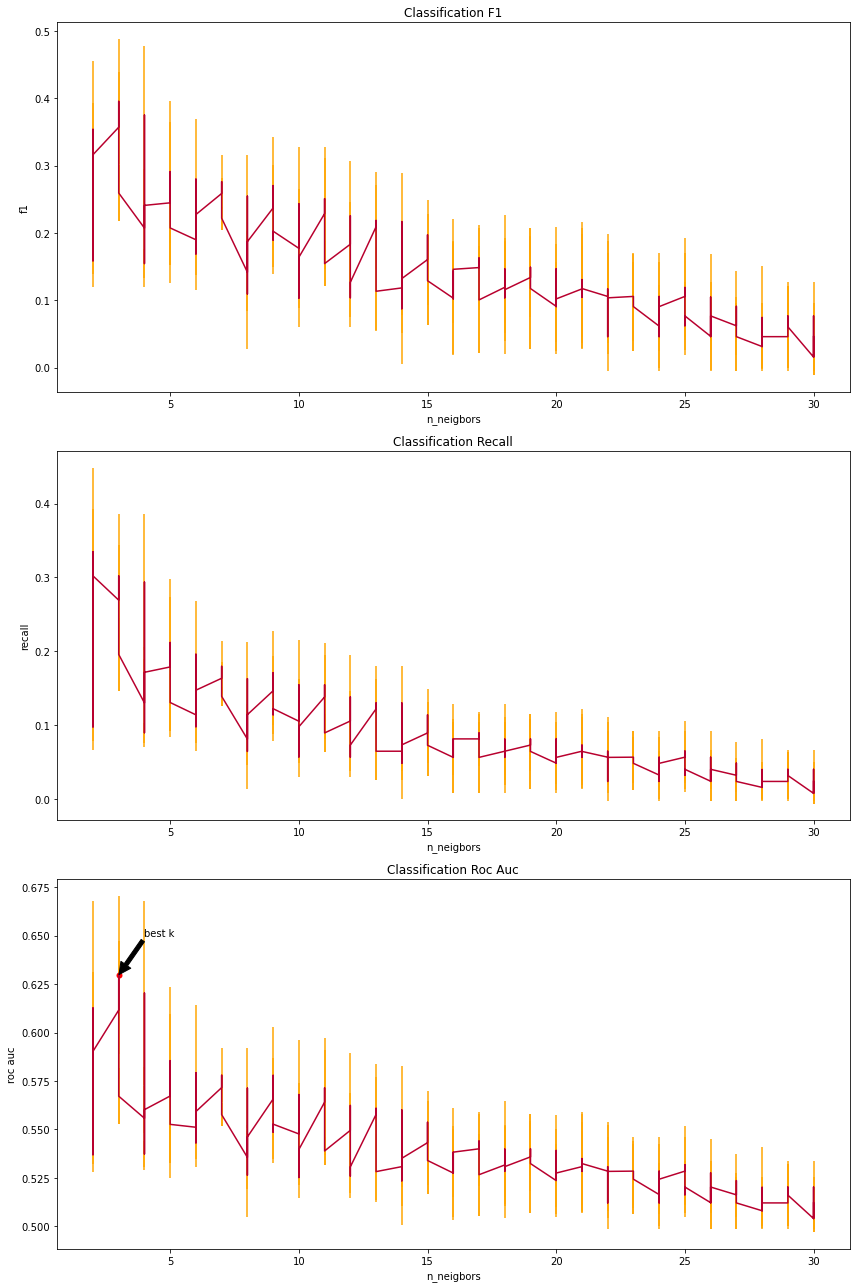



Permutation importances of the training set

OverTime                                           0.003032
Age                                                0.000401
RelationshipSatisfaction                           0.000392
JobInvolvement                                     0.000385
NumCompaniesWorked                                 0.000369
DistanceFromHome                                   0.000305
StockOptionLevel                                   0.000296
JobSatisfaction                                    0.000264
EnvironmentSatisfaction                            0.000248
WorkLifeBalance                                    0.000201
JobLevel                                           0.000053
TrainingTimesLastYear                              0.000025
OverallSatisfaction                                0.000025
JobRole                                            0.000013



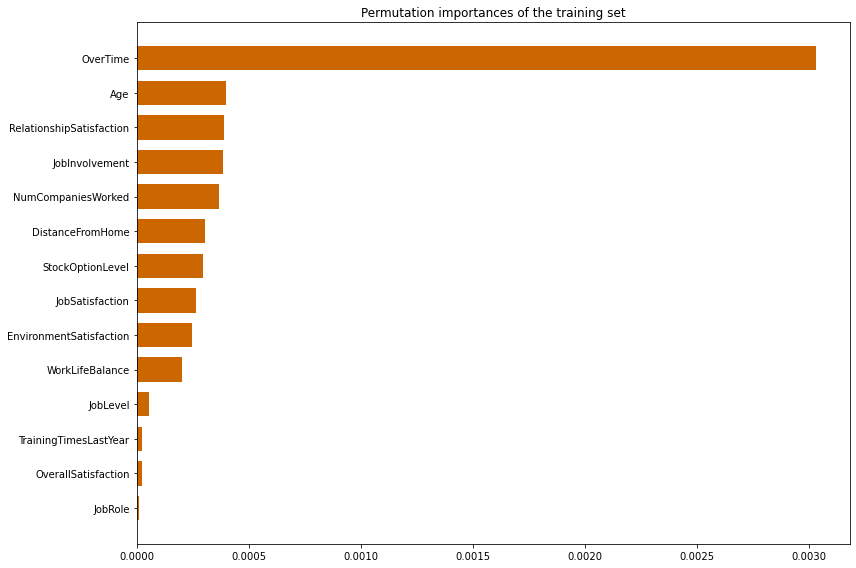



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.084258
OverTime                                           0.078248
WorkLifeBalance                                    0.077961
JobLevel                                           0.056286
JobSatisfaction                                    0.049735
Age                                                0.031960
JobRole                                            0.025066
NumCompaniesWorked                                 0.021874
RelationshipSatisfaction                           0.019543
OverallSatisfaction                                0.019278
DistanceFromHome                                   0.017863
EnvironmentSatisfaction                            0.010086
JobInvolvement                                     0.004110
TrainingTimesLastYear                              0.000817



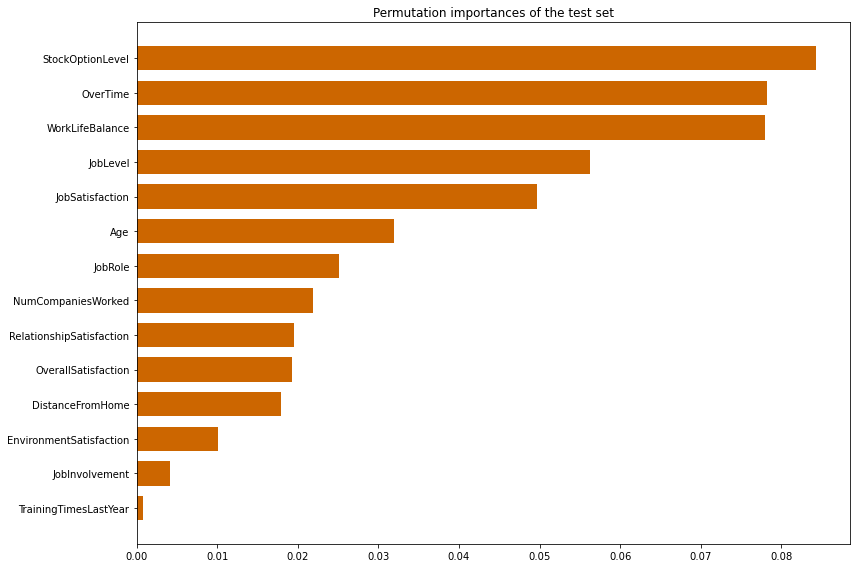



Confusion matrix


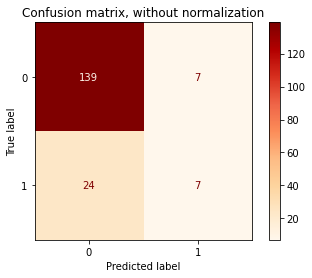

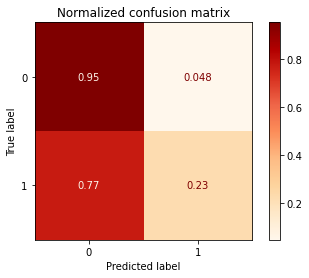


Classification report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       146
           1       0.50      0.23      0.31        31

    accuracy                           0.82       177
   macro avg       0.68      0.59      0.61       177
weighted avg       0.79      0.82      0.80       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.89967638 0.31111111]
Precision [0.85276074 0.5       ]
Recall [0.95205479 0.22580645]
Roc_auc 0.5889306230667256


Roc curve



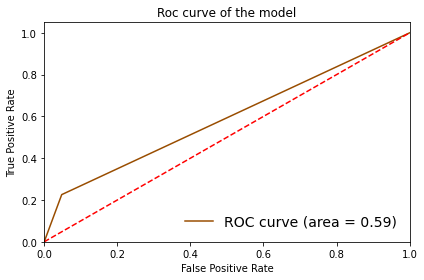


-------------------------------------------------------------------------------------------------------------



In [58]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [59]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.11262798634812286, 1.0],
   'tpr': [0.0, 0.36065573770491804, 1.0],
   'roc': 0.6240138756783976},
  '70-30': {'fpr': [0.0, 0.0365296803652968, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.6339090728608299},
  '80-20': {'fpr': [0.0, 0.13013698630136986, 1.0],
   'tpr': [0.0, 0.41935483870967744, 1.0],
   'roc': 0.6446089262041539}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.05802047781569966, 1.0],
   'tpr': [0.0, 0.2459016393442623, 1.0],
   'roc': 0.5939405807642814},
  '70-30': {'fpr': [0.0, 0.1324200913242009, 1.0],
   'tpr': [0.0, 0.391304347826087, 1.0],
   'roc': 0.629442128250943},
  '80-20': {'fpr': [0.0, 0.1095890410958904, 1.0],
   'tpr': [0.0, 0.3548387096774194, 1.0],
   'roc': 0.6226248342907645}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.034129692832764506, 1.0],
   'tpr': [0.0, 0.2459016393442623, 1.0],
   'roc': 0.605885973255749},
  '70-30': {'fpr': [0.0, 0.0091324200913242, 1.0],
   'tpr': [0.0, 0.21739130

In [64]:
temporal_info = {}

In [65]:
model_name = '15f numerical-encoded kmeans discretized'

In [66]:
temporal_info[model_name] = scaler_dict['MinMaxScaler']['80-20']
temporal_info

{'15f numerical-encoded kmeans discretized': {'fpr': [0.0,
   0.13013698630136986,
   1.0],
  'tpr': [0.0, 0.41935483870967744, 1.0],
  'roc': 0.6446089262041539}}

In [67]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['kmeans']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)